# Validation: Heldout Data Example

This notebook:

* loads a library defined model. 
* loads the data according to the data preprocessor class.
* holds-out the final few days of the data, and see's if they can be predicted. 

The way I propose doing this is holding out the confirmed observations for the final three days of the day for every country, and then plotting it for validation. This effectively changes the output model. 

In [83]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel.pymc3_models.utils import geom_convolution
from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor


%matplotlib inline

INFO:epimodel.regions:Name index has 6 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands']
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:
Countermeasures                               min   .. mean  .. max
 0 Gatherings limited to                      0.000 .. 0.177 .. 0.982
 1 Business suspended                         0.000 .. 0.273 .. 1.000
 2 Schools and universities closed            0.000 .. 0.361 .. 1.000
 3 General curfew                             0.000 .. 0.167 .. 1.000
 4 Healthcare specialisation                  0.000 .. 0.020 .. 0.429
 5 Phone line                                 0.000 .. 0.032 .. 1.000
 6 Asymptomatic contact isolation             0.000 .. 0.053 .. 1.000


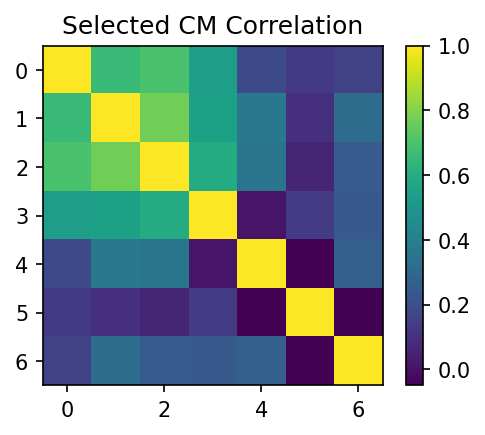

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Data Preprocessing Complete using:

{
    "start_date": "2020-2-10",
    "end_date": "2020-04-05",
    "min_final_num_active_cases": 100,
    "min_num_active_mask": 10,
    "min_num_confirmed_mask": 10
}


In [85]:
regions = ["PT", "IS", "HU", "HR", "BE", "NL", "DK", "DE", "AT", "CZ", "GE", "FR", "ES", "GB", "PL", "GR", "CH", "FI", "NO", "SE", "SI", "SK"]
features = ['Gatherings limited to', 'Business suspended', 'Schools and universities closed', 'General curfew',
       'Healthcare specialisation', 'Phone line', 'Asymptomatic contact isolation']

dp = DataPreprocessor()
data = dp.preprocess_data("../../data", regions, features)

In [153]:
with cm_effect.models.CMModelFlexibleV3(data) as model:
    model.build_all()

/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in Observed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
INFO:epimodel.pymc3_models.cm_effect.models:Checking model test point
INFO:epimodel.pymc3_models.cm_effect.models:
CMReduction_log__            -1.58
RegionGrowthRate_log__       -0.06
RegionNoiseScale_log__      -20.22
Growth_log__                850.70
InitialSize_log__           -70.87
Observed_missing              0.00
Observed                 -32343.58
Name: Log-probability of test_point, dtype: float64



In [154]:
model.run(2000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...


CMReduction_log__            -1.58
RegionGrowthRate_log__       -0.06
RegionNoiseScale_log__      -20.22
Growth_log__                850.70
InitialSize_log__           -70.87
Observed_missing              0.00
Observed                 -32343.58
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Observed_missing, InitialSize, Growth, RegionNoiseScale, RegionGrowthRate, CMReduction]
INFO:pymc3:NUTS: [Observed_missing, InitialSize, Growth, RegionNoiseScale, RegionGrowthRate, CMReduction]
Sampling 2 chains, 30 divergences: 100%|██████████| 5000/5000 [36:21<00:00,  2.29draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9594508690857617, but should be close to 0.8. Try to increase the number of tuning steps.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.904282894815023, but should be close to 

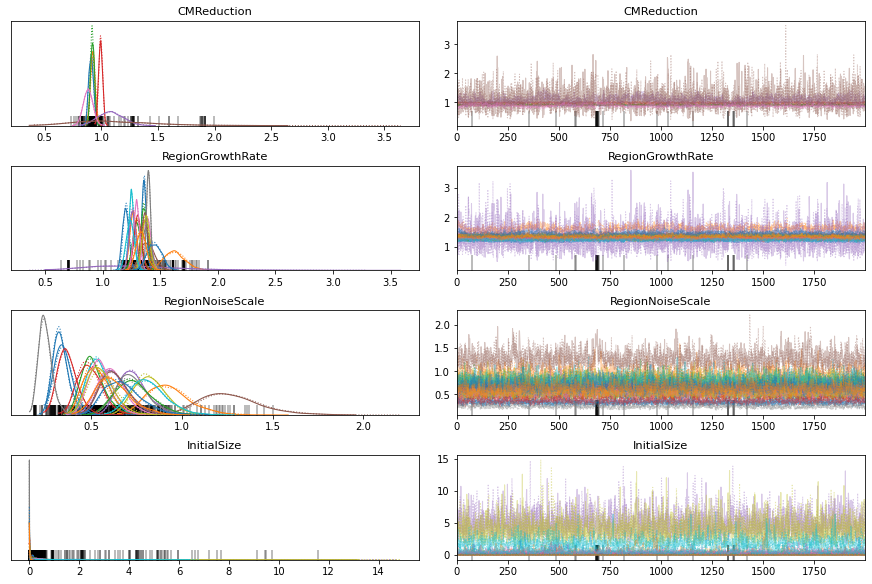

In [155]:
_ = model.plot_traces()

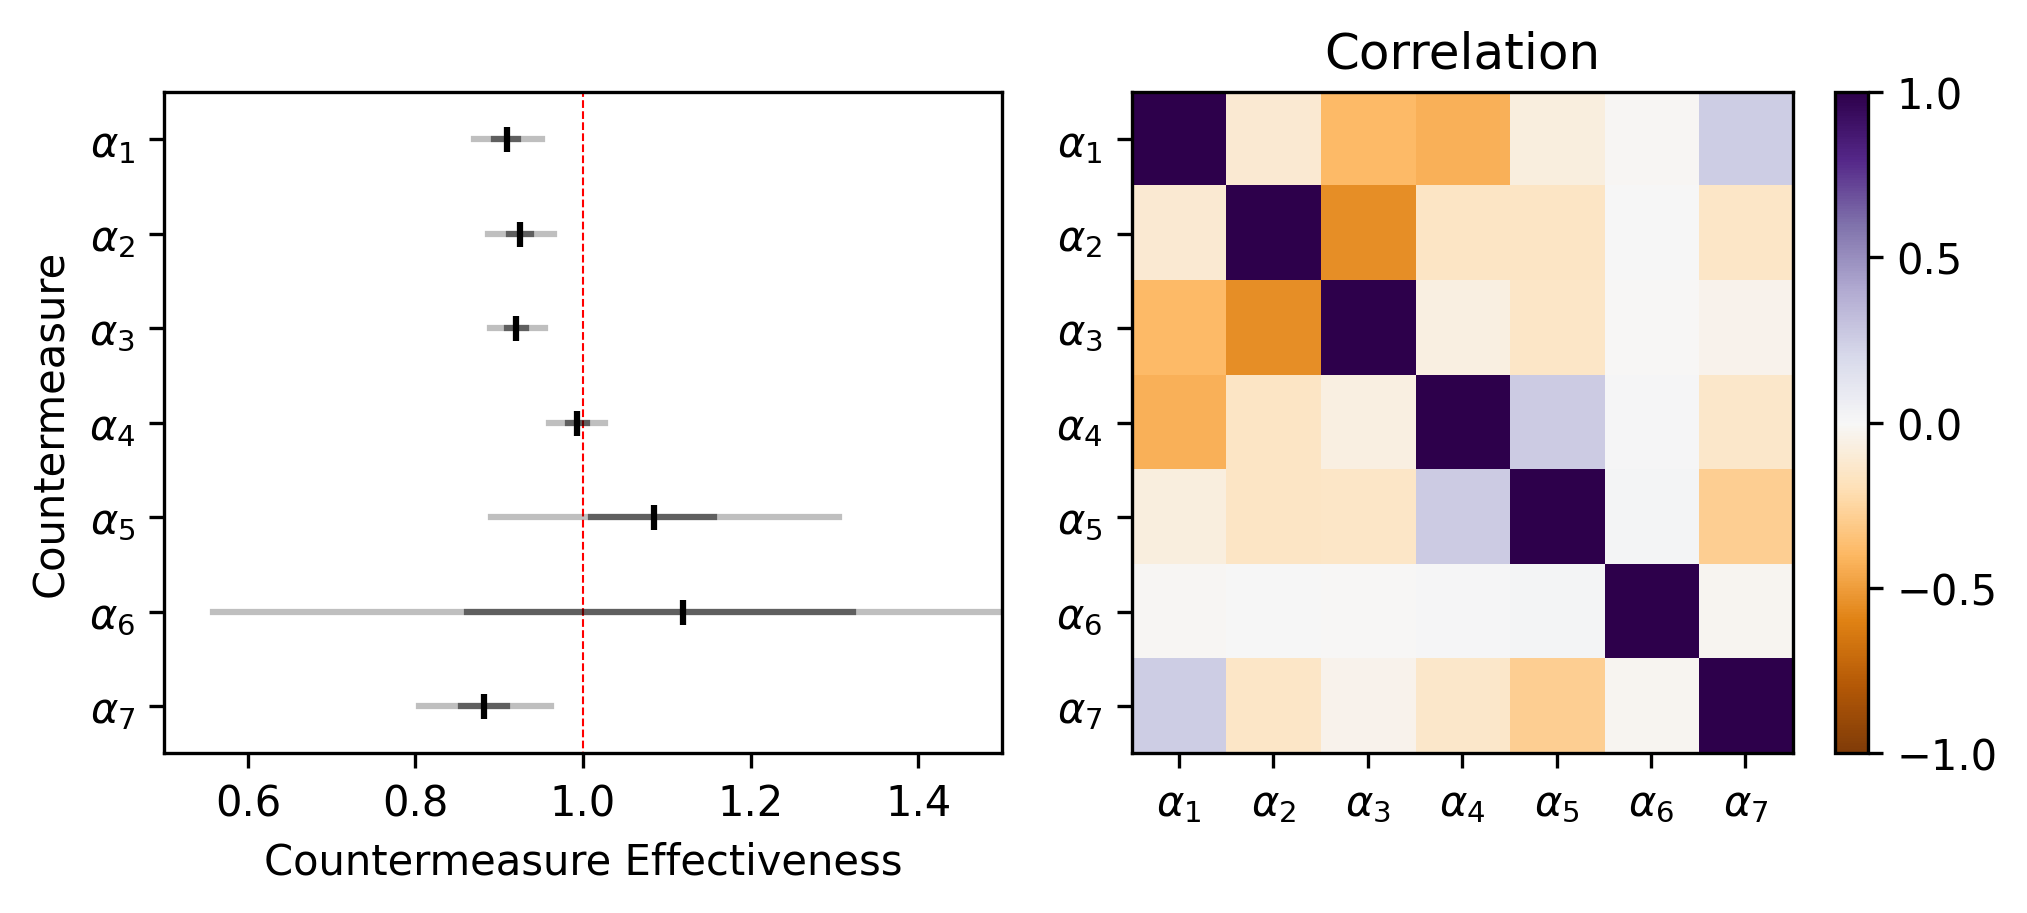

In [156]:
model.plot_effect()

In [274]:
model.d.ActiveCMs

array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1.]]])

In [163]:
labels.size

56

# Inspect Spain

Let's hold spain out. 

['AT', 'BE', 'CH', 'CZ', 'DE', 'DK', 'ES', 'FI', 'FR', 'GB', 'GE', 'GR', 'HR', 'HU', 'IS', 'NL', 'NO', 'PL', 'PT', 'SE', 'SI', 'SK']


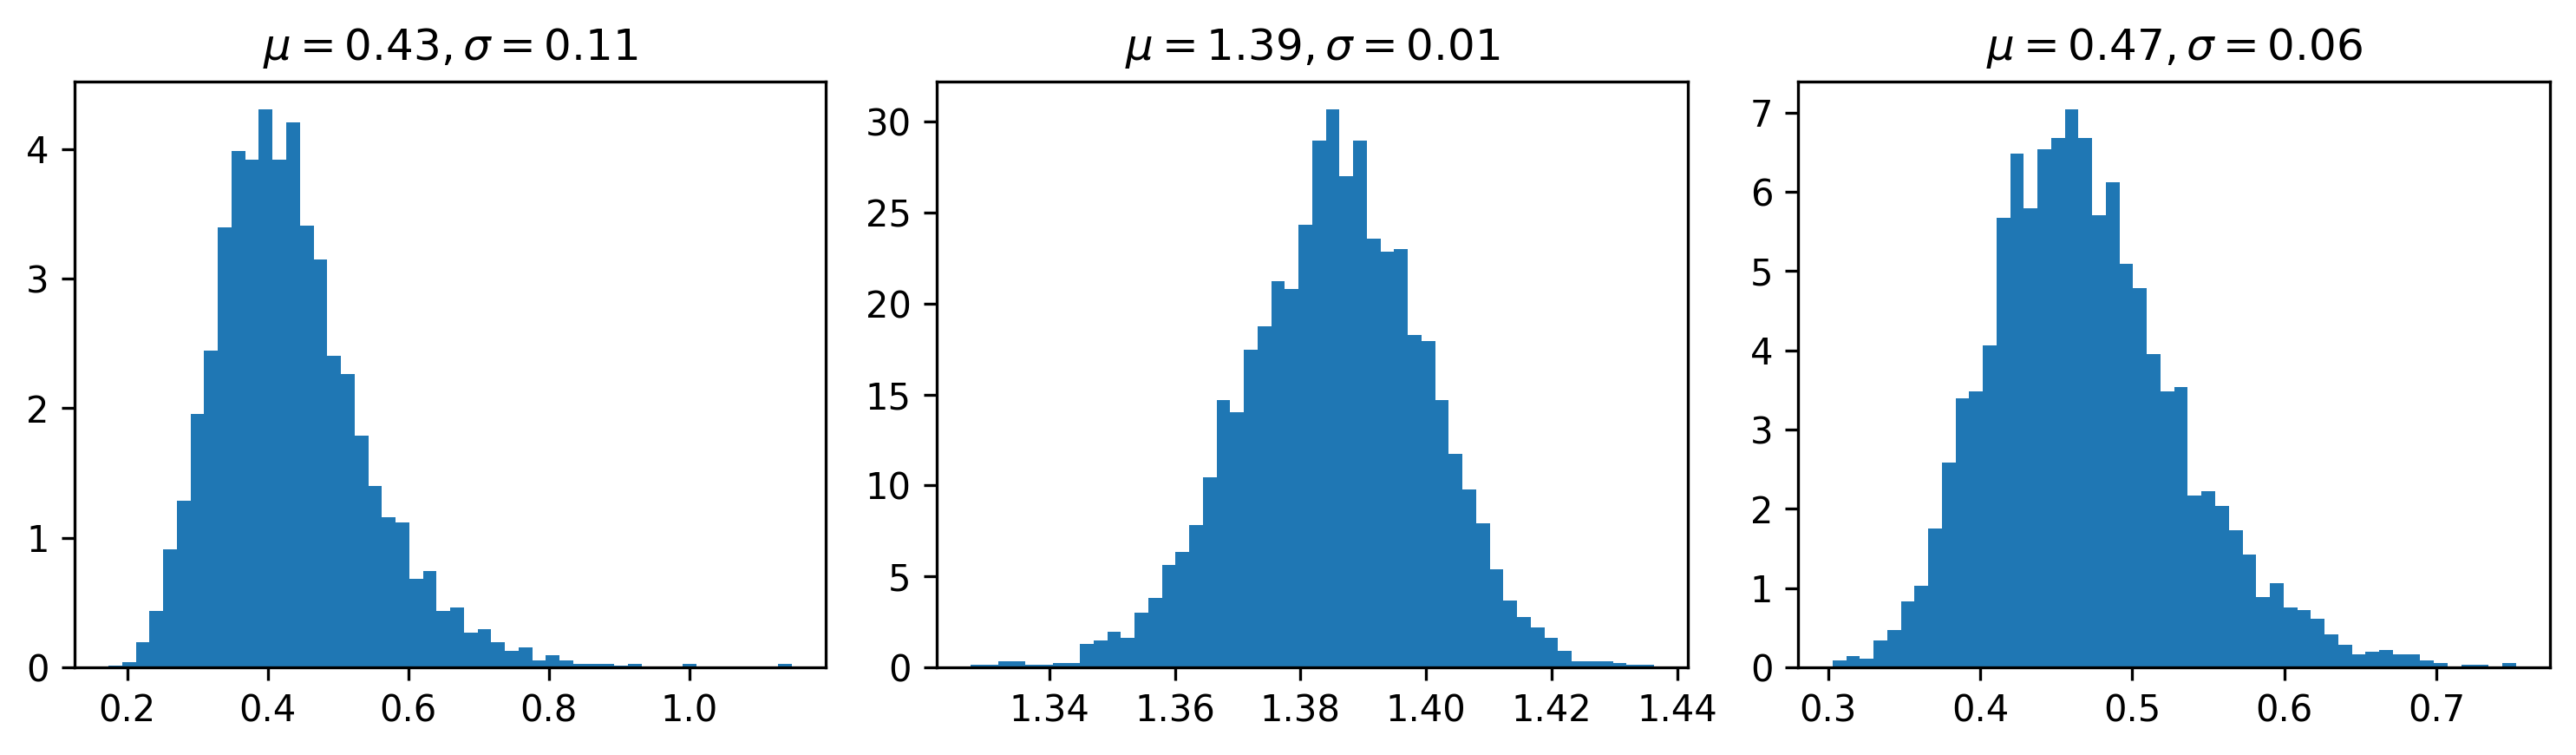

In [138]:
fig = plt.figure(figsize=(10, 3), dpi=300)
print(model.d.Rs)
plt.subplot(1, 3, 1)
plt.hist(model.trace["InitialSize"][:, 6], bins=50,  density=True)
plt.title(f"$\\mu = {np.mean(model.trace['InitialSize'][:, 6]):.2f}, \\sigma = {np.std(model.trace['InitialSize'][:, 6]):.2f}$") 
plt.subplot(1, 3, 2)
plt.hist(model.trace["RegionGrowthRate"][:, 6], bins=50,  density=True)
plt.title(f"$\\mu = {np.mean(model.trace['RegionGrowthRate'][:, 6]):.2f}, \\sigma = {np.std(model.trace['RegionGrowthRate'][:, 6]):.2f}$")
plt.subplot(1, 3, 3)
plt.hist(model.trace["RegionNoiseScale"][:, 6], bins=50,  density=True)
plt.title(f"$\\mu = {np.mean(model.trace['RegionNoiseScale'][:, 6]):.2f}, \\sigma = {np.std(model.trace['RegionNoiseScale'][:, 6]):.2f}$") 
plt.tight_layout()

Worth noting that these distributions don't look particularly Gaussian for when we want to provide initial estimates. I'll use a normal distribution though. 

In [143]:
with cm_effect.models.CMModelFlexibleV3(data, heldout_regions=["ES"]) as model2:
    model2.build_cm_reduction_prior()
    model2.build_region_growth_prior()
    model2.build_region_reliability_prior()
    model2.build_heldout_region_priors(pm.Normal, {"mu": 0.43, "sigma": 0.11}, pm.Normal, {"mu": 1.39, "sigma": 0.03}, pm.Normal, {"mu": 0.47, "sigma": 0.06})
    model2.build_rates()
    model2.build_output_model()

/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in Observed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [144]:
model2.run(2000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...


CMReduction_log__            -1.58
RegionGrowthRate_log__       -0.06
RegionNoiseScale_log__      -19.30
HeldoutInitialSize            1.29
HeldoutGrowthRate             2.59
HeldoutNoiseScale             1.89
Growth_log__               1627.17
HeldoutGrowth_log__         119.77
InitialSize_log__           -67.65
Observed_missing              0.00
HeldoutConfirmed_log__       42.13
Observed                 -10813.95
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [HeldoutConfirmed, Observed_missing, InitialSize, HeldoutGrowth, Growth, HeldoutNoiseScale, HeldoutGrowthRate, HeldoutInitialSize, RegionNoiseScale, RegionGrowthRate, CMReduction]
INFO:pymc3:NUTS: [HeldoutConfirmed, Observed_missing, InitialSize, HeldoutGrowth, Growth, HeldoutNoiseScale, HeldoutGrowthRate, HeldoutInitialSize, RegionNoiseScale, RegionGrowthRate, CMReduction]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [21:59<00:00,  3.79draws/s] 
The acceptance probability does not match the target. It is 0.9581947005455177, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9394659110408766, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
INFO:pymc3:The rha

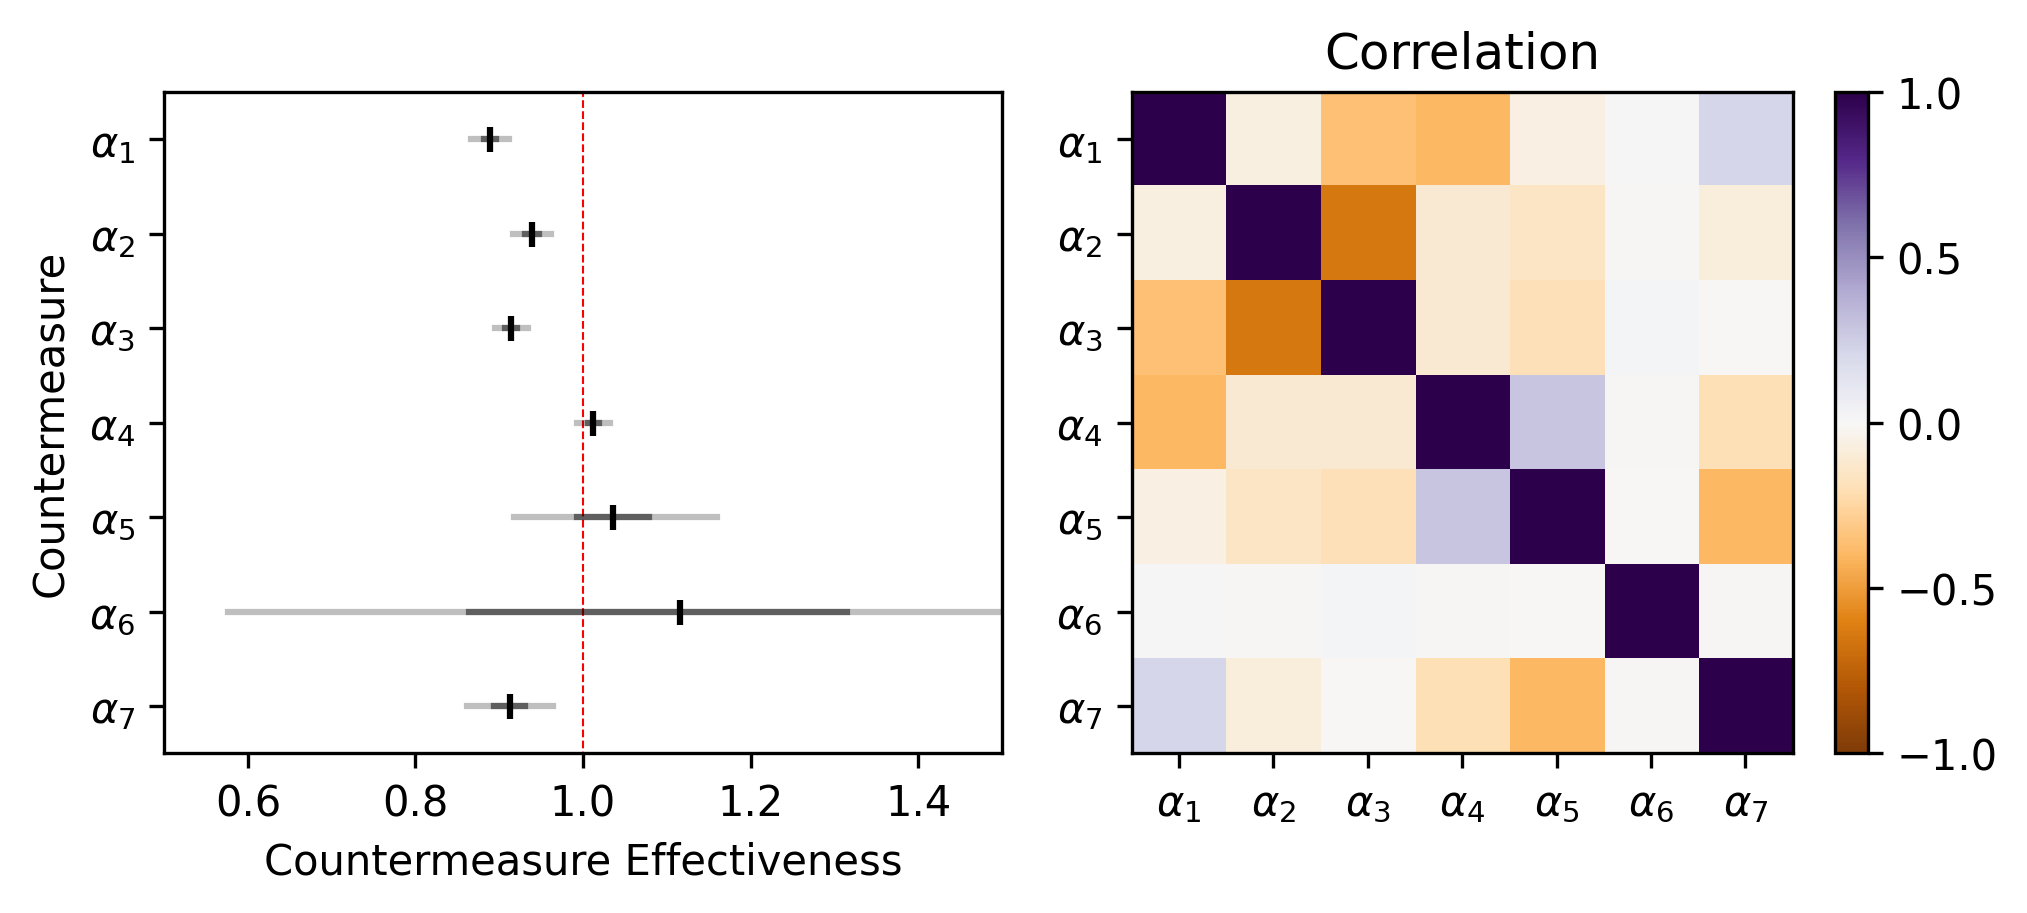

In [145]:
model2.plot_effect()

INFO:epimodel.pymc3_models.cm_effect.models:Saving Day Validation Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/heldout_validation/out


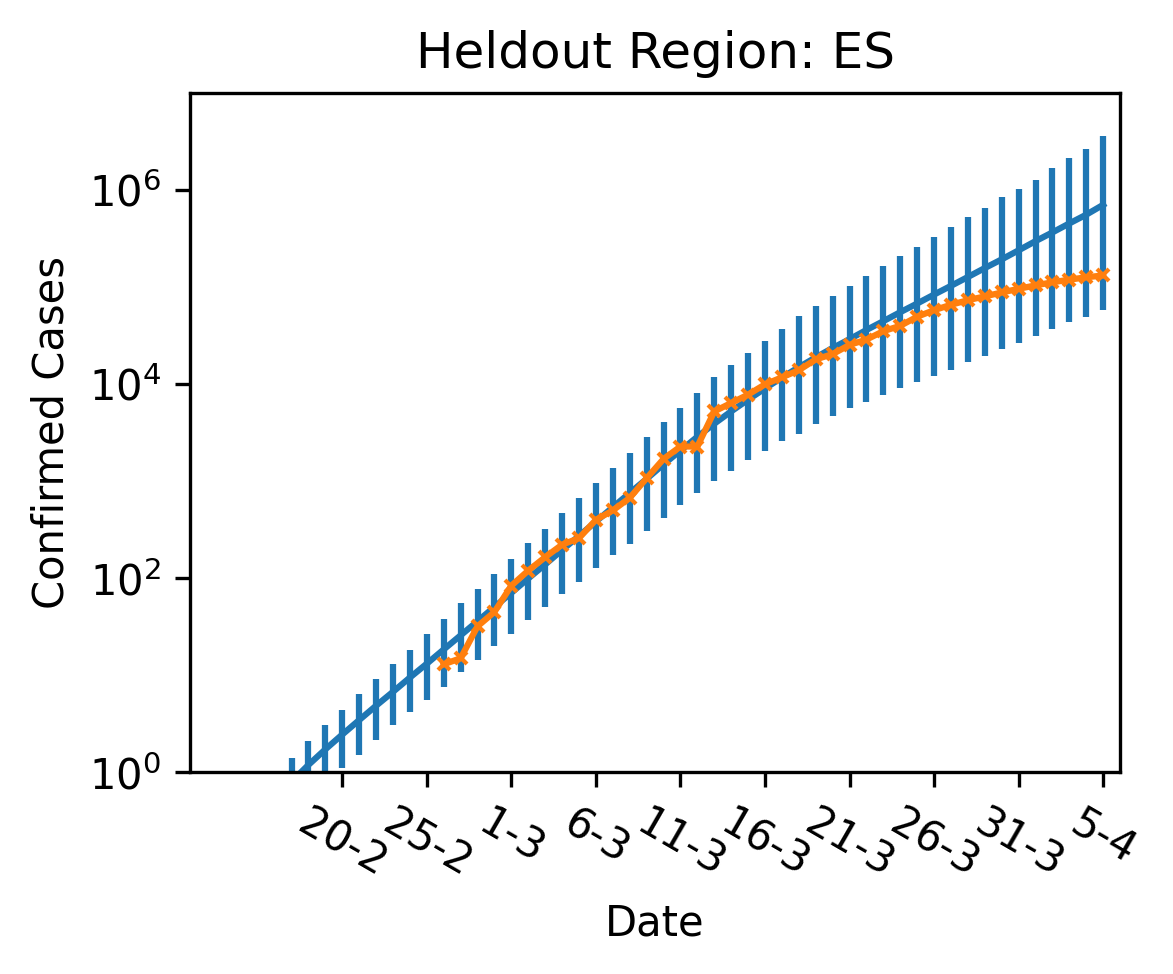

In [146]:
model2.heldout_regions_validation_plot()

# Let's holdout the final 3 days. 

In [148]:
with cm_effect.models.CMModelFlexibleV3(data, heldout_days=[53, 54, 55]) as model3:
    model3.build_all()

/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in Observed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
INFO:epimodel.pymc3_models.cm_effect.models:Checking model test point
INFO:epimodel.pymc3_models.cm_effect.models:
CMReduction_log__               -1.58
RegionGrowthRate_log__          -0.06
RegionNoiseScale_log__         -20.22
Growth_log__                  1704.65
InitialSize_log__              -70.87
Observed_missing                 0.00
HeldoutDaysObserved_log__       -0.17
Observed                    -11128.08
Name: Log-probability of test_point, dtype: float64



In [149]:
model3.run(2000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...


CMReduction_log__               -1.58
RegionGrowthRate_log__          -0.06
RegionNoiseScale_log__         -20.22
Growth_log__                  1704.65
InitialSize_log__              -70.87
Observed_missing                 0.00
HeldoutDaysObserved_log__       -0.17
Observed                    -11128.08
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [HeldoutDaysObserved, Observed_missing, InitialSize, Growth, RegionNoiseScale, RegionGrowthRate, CMReduction]
INFO:pymc3:NUTS: [HeldoutDaysObserved, Observed_missing, InitialSize, Growth, RegionNoiseScale, RegionGrowthRate, CMReduction]
Sampling 2 chains, 3 divergences: 100%|██████████| 5000/5000 [24:26<00:00,  3.41draws/s] 
The acceptance probability does not match the target. It is 0.9359453211526988, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9616980405441696, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR

INFO:epimodel.pymc3_models.cm_effect.models:Saving Day Validation Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/heldout_validation/out
INFO:epimodel.pymc3_models.cm_effect.models:Saving Day Validation Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/heldout_validation/out
INFO:epimodel.pymc3_models.cm_effect.models:Saving Day Validation Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/heldout_validation/out


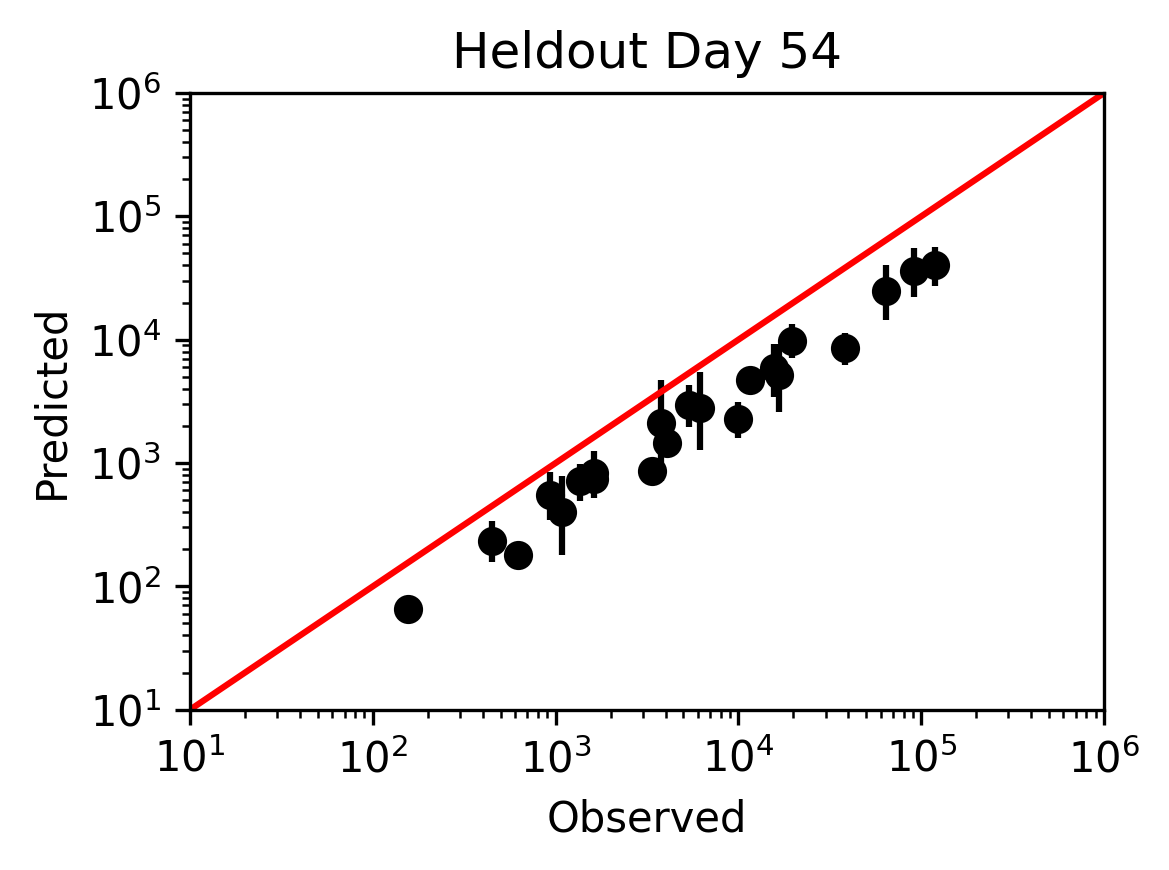

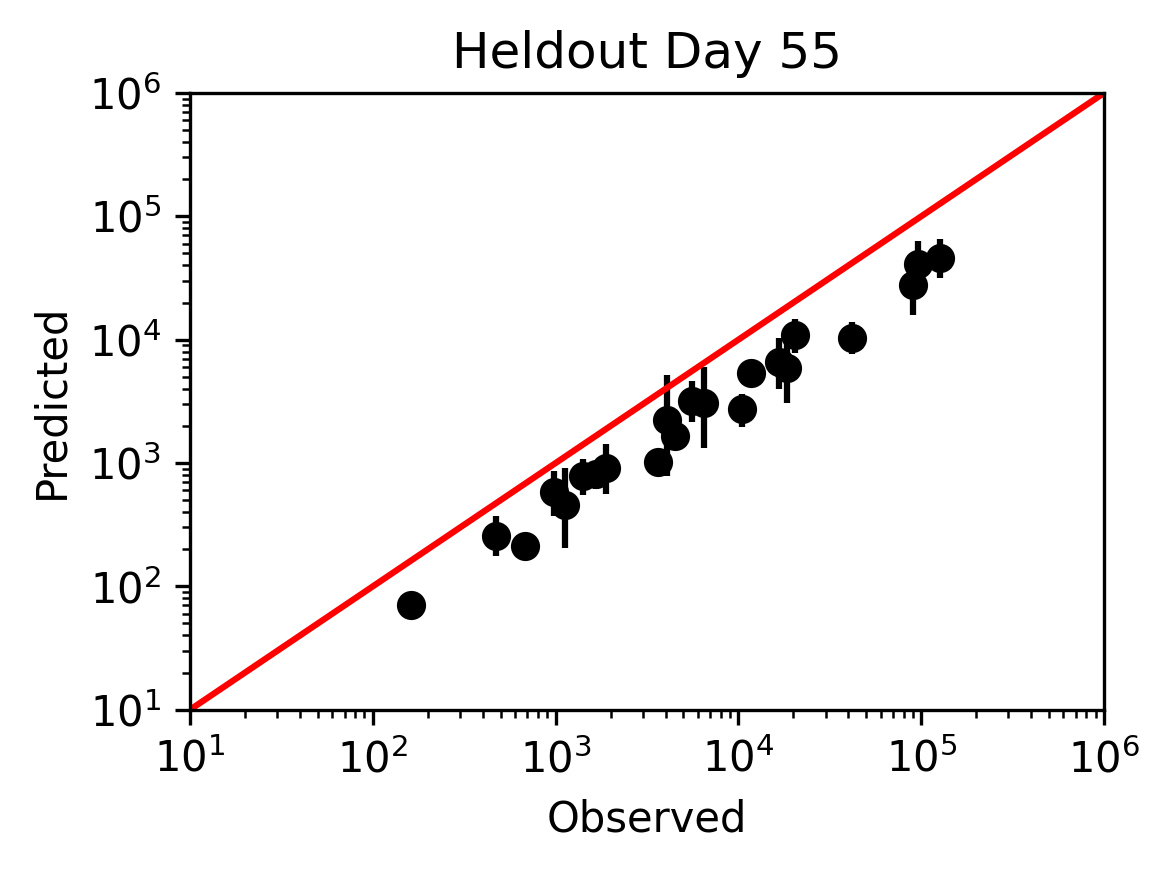

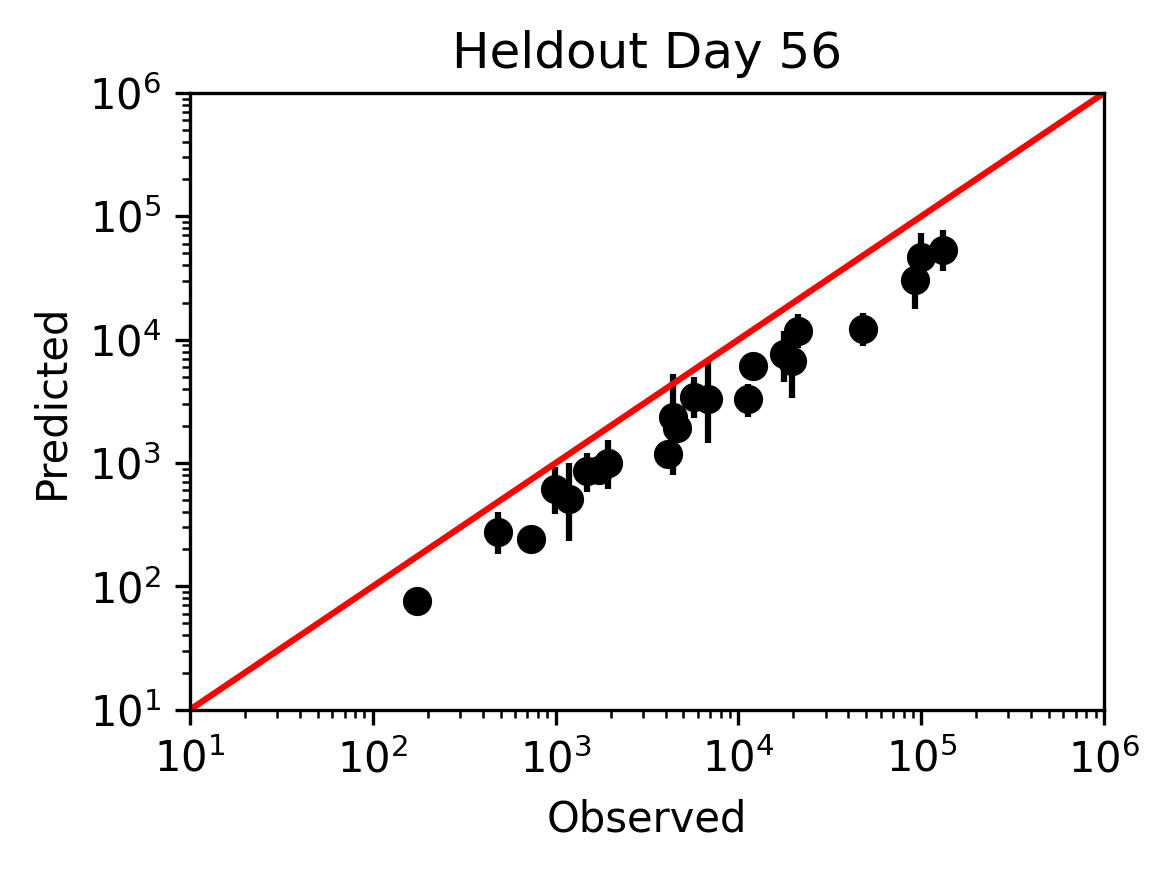

In [150]:
model3.heldout_days_validation_plot()

# Sanity Checks

Let's run one model only. It should attribute all affect to the gathering. It should use the first noise to model changes in testing too. 

INFO:epimodel.regions:Name index has 6 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands']
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:
Countermeasures                               min   .. mean  .. max
 0 Business suspended                         0.000 .. 0.351 .. 1.000


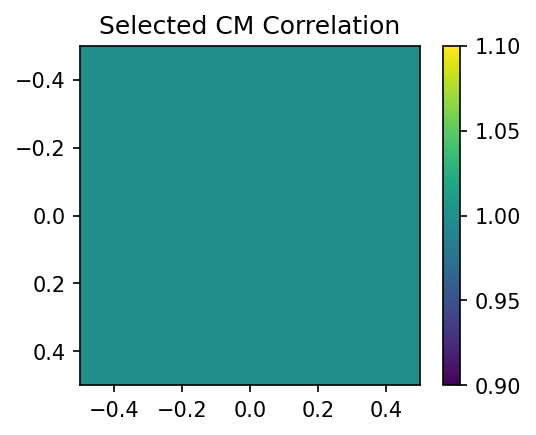

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Data Preprocessing Complete using:

{
    "start_date": "2020-2-10",
    "end_date": "2020-04-05",
    "min_final_num_active_cases": 100,
    "min_num_active_mask": 10,
    "min_num_confirmed_mask": 10
}


In [255]:
regions = ["ES", ]
features = ['Business suspended']

features_full = ['Gatherings limited to', 'Business suspended', 'Schools and universities closed', 'General curfew',
       'Healthcare specialisation', 'Phone line', 'Asymptomatic contact isolation']

dp = DataPreprocessor()
data = dp.preprocess_data("../../data", regions, features)

In [267]:
with cm_effect.models.CMModelFlexibleV3(data, heldout_days=[54, 55, 56]) as model:
    model.build_all()

/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in Observed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
INFO:epimodel.pymc3_models.cm_effect.models:Checking model test point
INFO:epimodel.pymc3_models.cm_effect.models:
CMReduction_log__              -0.23
RegionGrowthRate_log__         -0.00
RegionNoiseScale_log__         -0.92
Growth_log__                   77.48
InitialSize_log__              -3.22
Observed_missing                0.00
HeldoutDaysObserved_log__       2.07
Observed                    -4863.14
Name: Log-probability of test_point, dtype: float64



In [268]:
model.run(2000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...


CMReduction_log__              -0.23
RegionGrowthRate_log__         -0.00
RegionNoiseScale_log__         -0.92
Growth_log__                   77.48
InitialSize_log__              -3.22
Observed_missing                0.00
HeldoutDaysObserved_log__       2.07
Observed                    -4863.14
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [HeldoutDaysObserved, Observed_missing, InitialSize, Growth, RegionNoiseScale, RegionGrowthRate, CMReduction]
INFO:pymc3:NUTS: [HeldoutDaysObserved, Observed_missing, InitialSize, Growth, RegionNoiseScale, RegionGrowthRate, CMReduction]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [02:03<00:00, 40.42draws/s]
The acceptance probability does not match the target. It is 0.8808196704064921, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1570c87d0>,
      dtype=object)

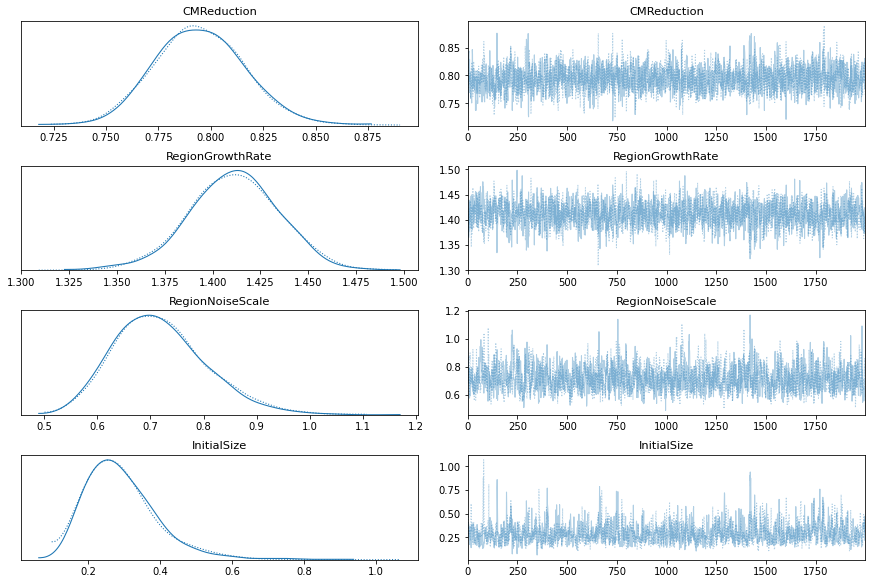

In [269]:
model.plot_traces()

(10, 1000000)

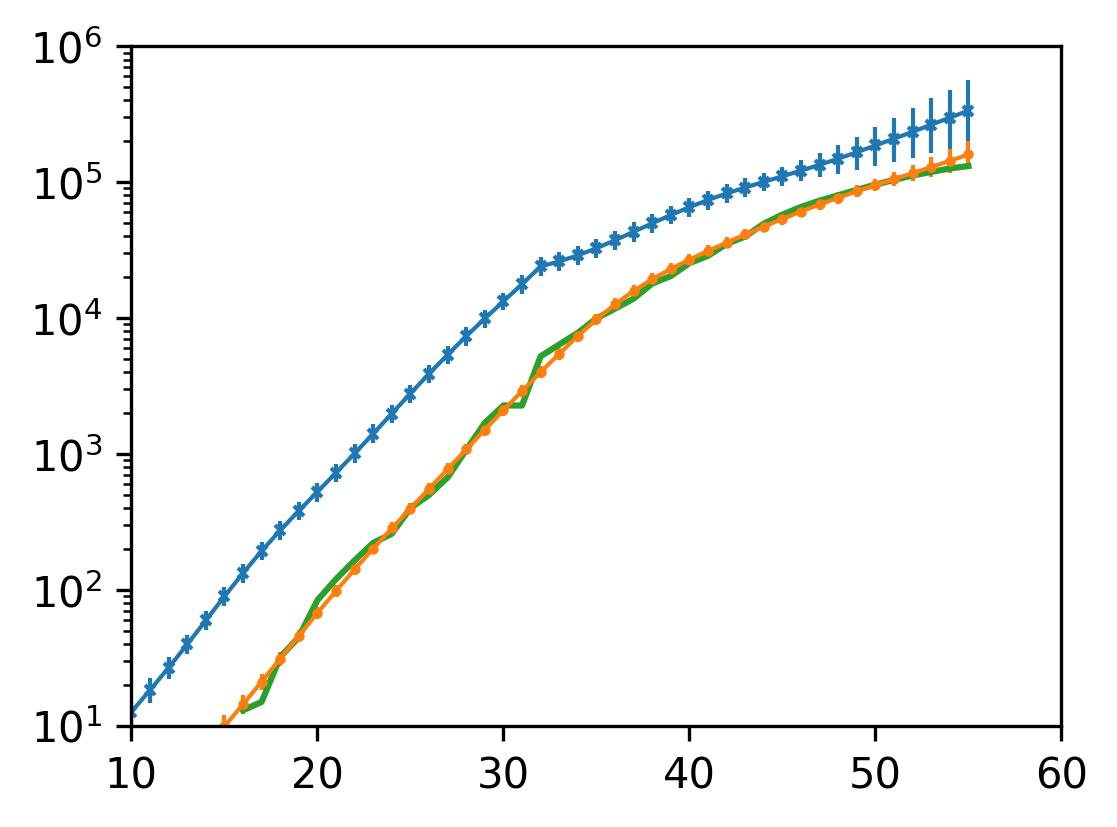

In [273]:
country_indx = 0
means = np.mean(model.trace.Infected[:, country_indx, :], axis=0)
li = np.percentile(model.trace.Infected[:, country_indx, :], 2.5, axis=0)
ui = np.percentile(model.trace.Infected[:, country_indx, :], 97.5, axis=0)
err = np.array([means-li, ui-means])

means_delayed = np.mean(model.trace.ExpectedConfirmed[:, country_indx, :], axis=0)
li_delayed = np.percentile(model.trace.ExpectedConfirmed[:, country_indx, :], 2.5, axis=0)
ui_delayed = np.percentile(model.trace.ExpectedConfirmed[:, country_indx, :], 97.5, axis=0)
err_delayed = np.array([means_delayed-li_delayed, ui_delayed-means_delayed])

labels = model.d.Confirmed[0, :]

max_val = 10 ** np.ceil(np.log10(max(np.max(ui), np.max(labels))))
min_val = 10 ** np.floor(np.log10(min(np.min(li), np.min(labels))))

plt.figure(figsize=(4, 3), dpi=300)
plt.errorbar(np.arange(56), means, yerr=err, fmt="-x", linewidth=1, markersize=2.5)
plt.errorbar(np.arange(56), means_delayed, yerr=err_delayed, fmt="-o", linewidth=1, markersize=1.5)
plt.plot(labels)
ax = plt.gca()
ax.set_yscale("log")
plt.plot([0, 10 ** 6], [0, 10 ** 6], "-r")
plt.xlim([10, 60]);
plt.ylim([10, 10**6])

<ErrorbarContainer object of 3 artists>

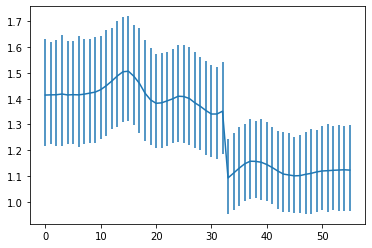

In [271]:
mean_growth = np.mean(model.trace.Growth[:, 0, :], axis=0)
ui_growth = np.percentile(model.trace.Growth[:, 0, :], 97.5, axis=0)
li_growth = np.percentile(model.trace.Growth[:, 0, :], 2.5, axis=0)
err_growth = np.array([mean_growth -li_growth, ui_growth-mean_growth])

plt.errorbar(np.arange(56), mean_growth, err_growth)

<ErrorbarContainer object of 3 artists>

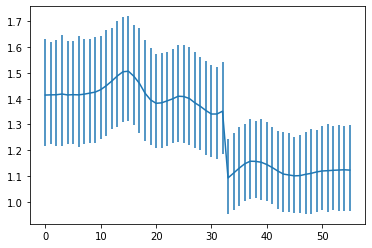

In [272]:
mean_growth = np.mean(model.trace.Growth[:, 0, :], axis=0)
ui_growth = np.percentile(model.trace.Growth[:, 0, :], 97.5, axis=0)
li_growth = np.percentile(model.trace.Growth[:, 0, :], 2.5, axis=0)
err_growth = np.array([mean_growth -li_growth, ui_growth-mean_growth])

plt.errorbar(np.arange(56), mean_growth, err_growth)


In [262]:
sizes = model.trace.InitialSize * np.cumprod(model.trace.Growth, axis=0)

In [263]:
sizes.shape

(4000, 4000, 56)

In [264]:
cum_prod = np.cumprod(model.trace.Growth, axis=2)

In [265]:
expected_size = model.trace.InitialSize.reshape((4000, 1, 1)) * cum_prod

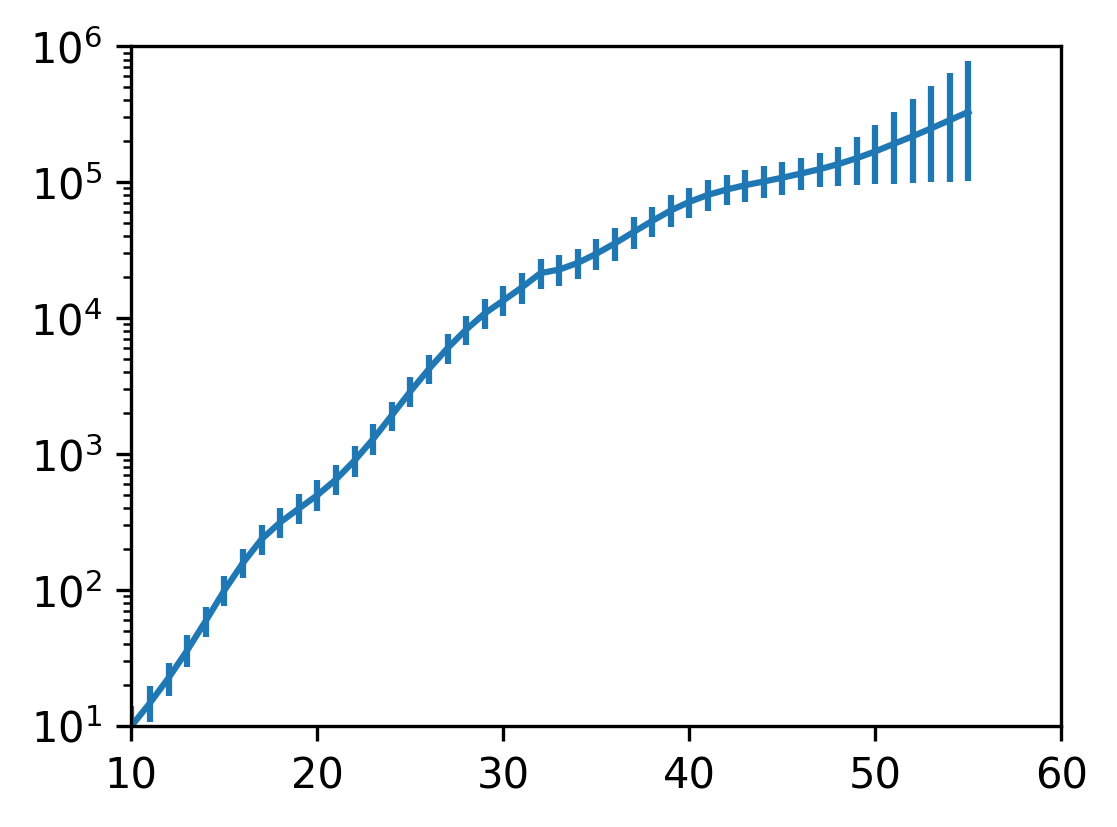

In [266]:
mean_growth = np.mean(expected_size[:, 0, :], axis=0)
ui_growth = np.percentile(expected_size[:, 0, :], 97.5, axis=0)
li_growth = np.percentile(expected_size[:, 0, :], 2.5, axis=0)
err_growth = np.array([mean_growth -li_growth, ui_growth-mean_growth])

plt.figure(figsize=(4, 3), dpi=300)
plt.errorbar(np.arange(56), mean_growth, err_growth)
ax = plt.gca()
ax.set_yscale("log")
plt.xlim([10, 60]);
plt.ylim([10, 10**6]);

# Lets try a different growth noise model. 

INFO:epimodel.regions:Name index has 6 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands']
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:
Countermeasures                               min   .. mean  .. max
 0 Gatherings limited to                      0.000 .. 0.177 .. 0.982
 1 Business suspended                         0.000 .. 0.273 .. 1.000
 2 Schools and universities closed            0.000 .. 0.361 .. 1.000
 3 General curfew                             0.000 .. 0.167 .. 1.000
 4 Healthcare specialisation                  0.000 .. 0.020 .. 0.429
 5 Phone line                                 0.000 .. 0.032 .. 1.000
 6 Asymptomatic contact isolation             0.000 .. 0.053 .. 1.000


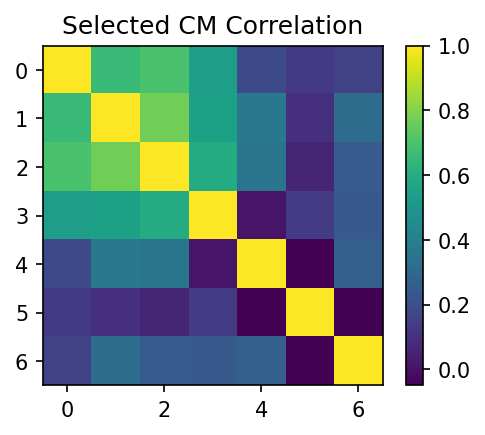

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Data Preprocessing Complete using:

{
    "start_date": "2020-2-10",
    "end_date": "2020-04-05",
    "min_final_num_active_cases": 100,
    "min_num_active_mask": 10,
    "min_num_confirmed_mask": 10
}
/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in Observed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [277]:
regions = ["PT", "IS", "HU", "HR", "BE", "NL", "DK", "DE", "AT", "CZ", "GE", "FR", "ES", "GB", "PL", "GR", "CH", "FI", "NO", "SE", "SI", "SK"]
features = ['Gatherings limited to', 'Business suspended', 'Schools and universities closed', 'General curfew',
       'Healthcare specialisation', 'Phone line', 'Asymptomatic contact isolation']

dp = DataPreprocessor()
data = dp.preprocess_data("../../data", regions, features)

with cm_effect.models.CMModelFlexibleV3(data, heldout_days=[54, 55, 56]) as model:
    model.build_cm_reduction_prior()
    model.build_region_growth_prior()
    model.build_region_reliability_prior()
    model.build_rates(pm.Normal, {"sigma": 0.05})
    model.build_output_model()

In [278]:
model.run(2000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...


CMReduction_log__               -1.58
RegionGrowthRate_log__          -0.06
RegionNoiseScale_log__         -20.22
Growth                        2558.61
InitialSize_log__              -70.87
Observed_missing                 0.00
HeldoutDaysObserved_log__       45.57
Observed                    -30215.98
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [HeldoutDaysObserved, Observed_missing, InitialSize, Growth, RegionNoiseScale, RegionGrowthRate, CMReduction]
INFO:pymc3:NUTS: [HeldoutDaysObserved, Observed_missing, InitialSize, Growth, RegionNoiseScale, RegionGrowthRate, CMReduction]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [25:21<00:00,  3.29draws/s]
The acceptance probability does not match the target. It is 0.9656750719200738, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9364069849880094, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


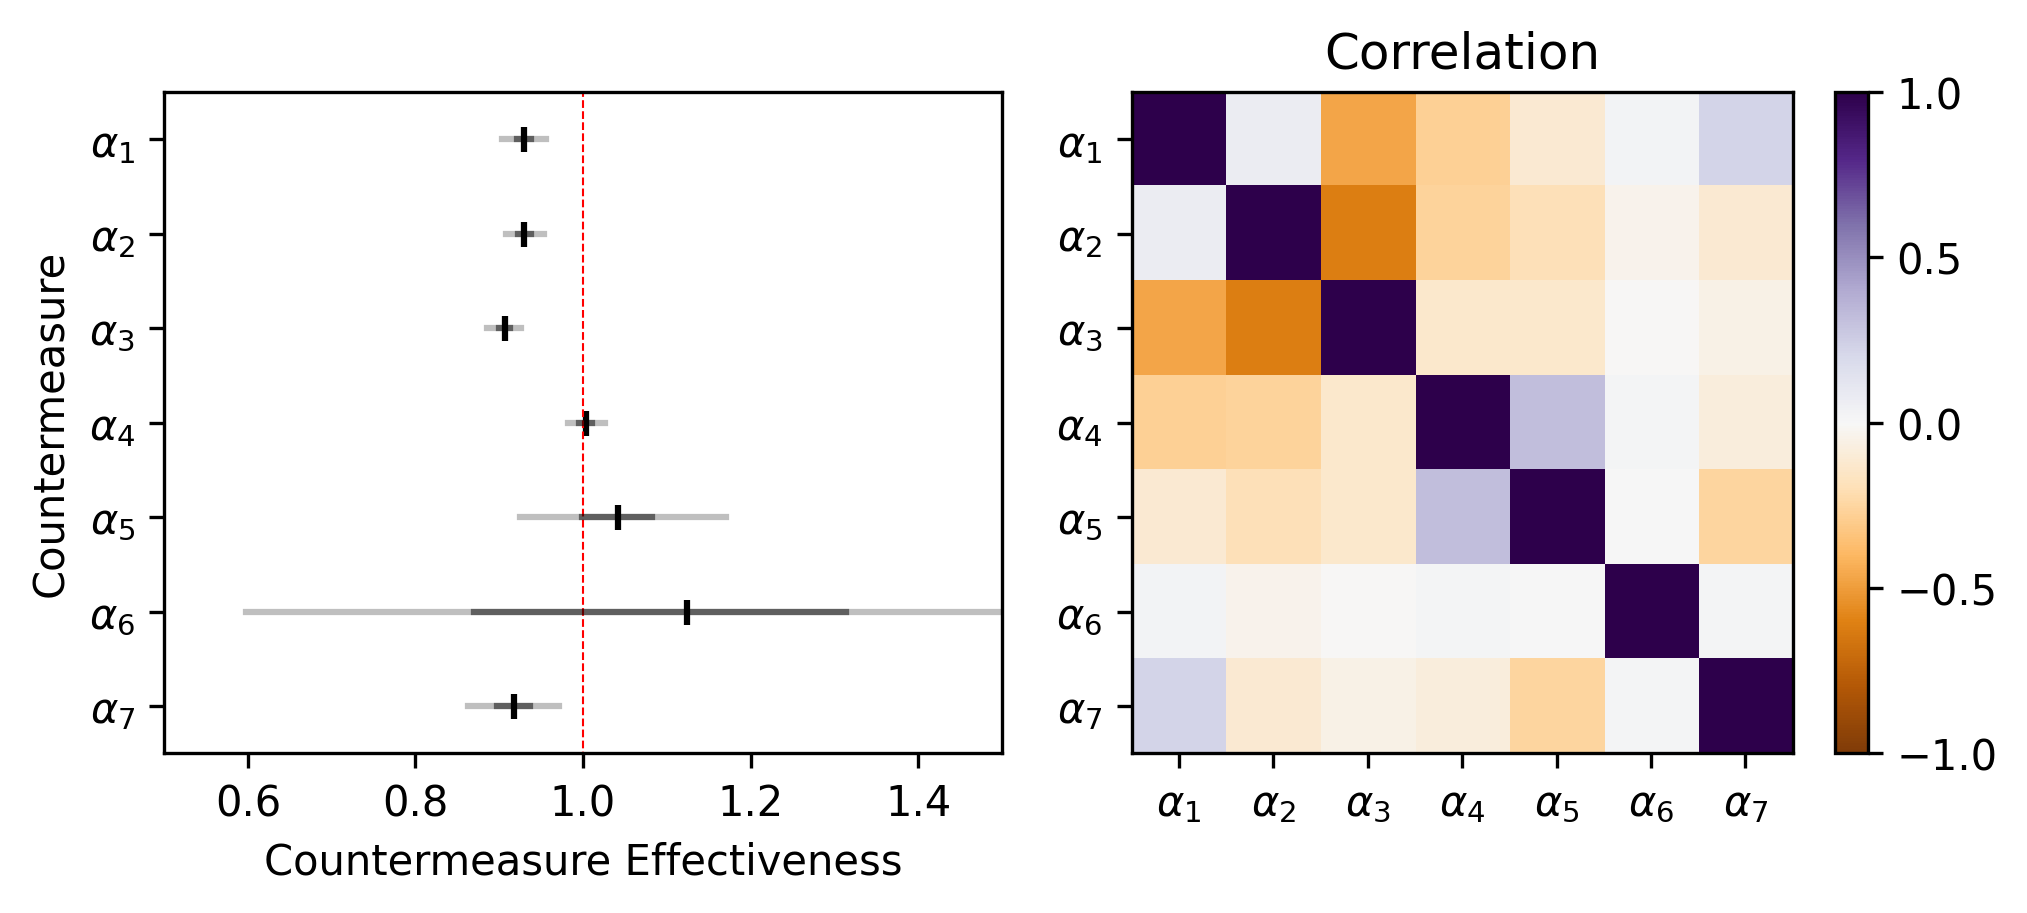

In [279]:
model.plot_effect()

/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


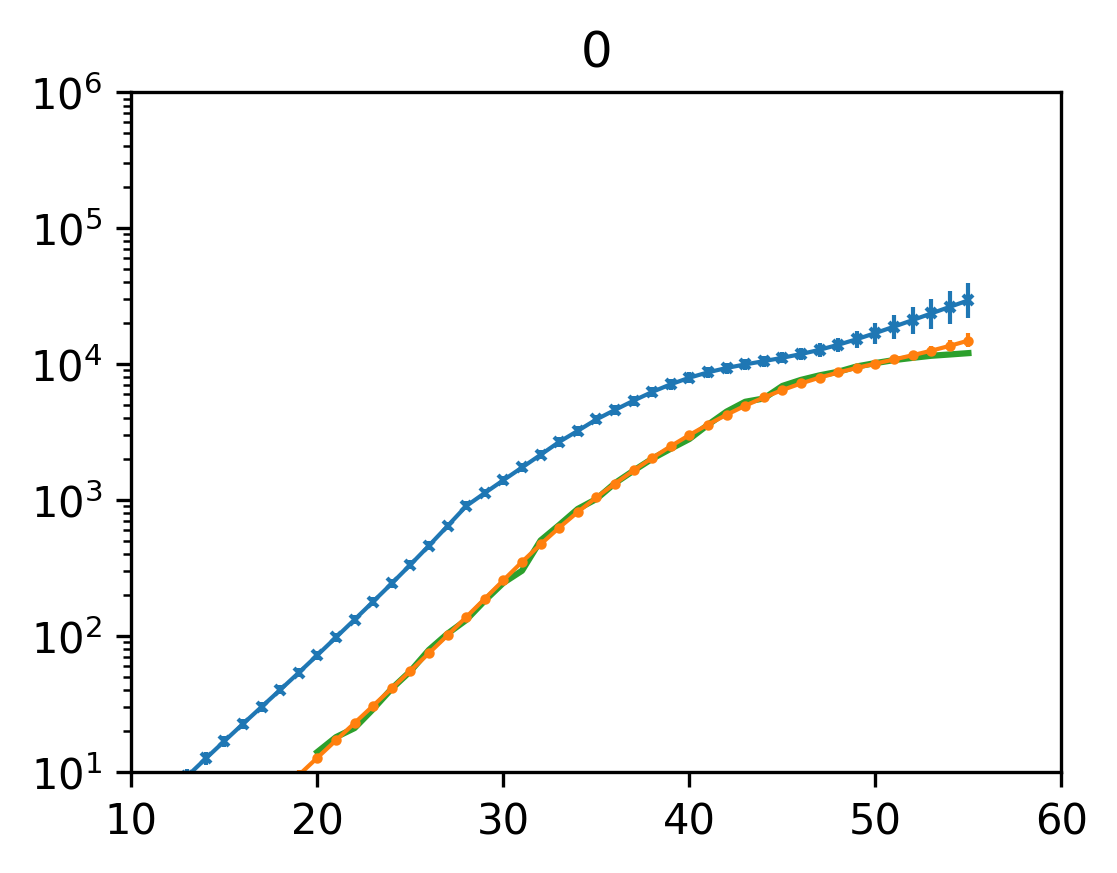

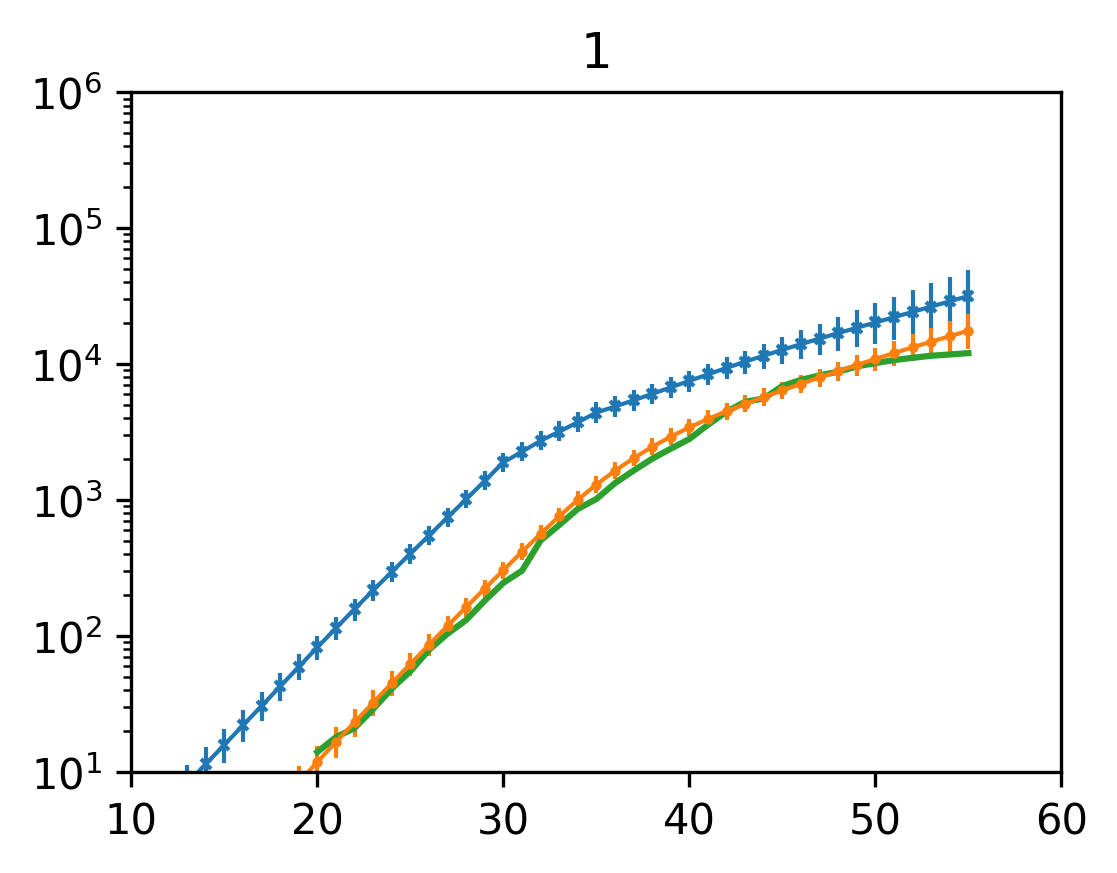

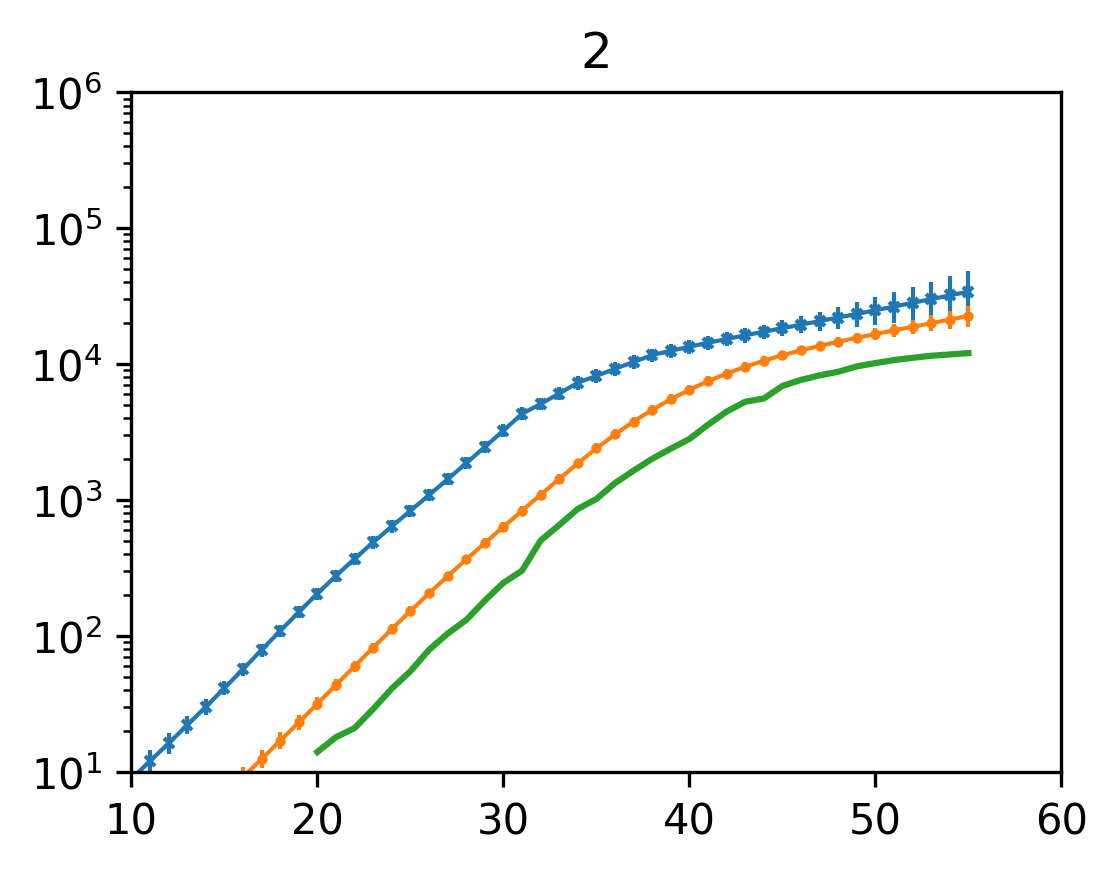

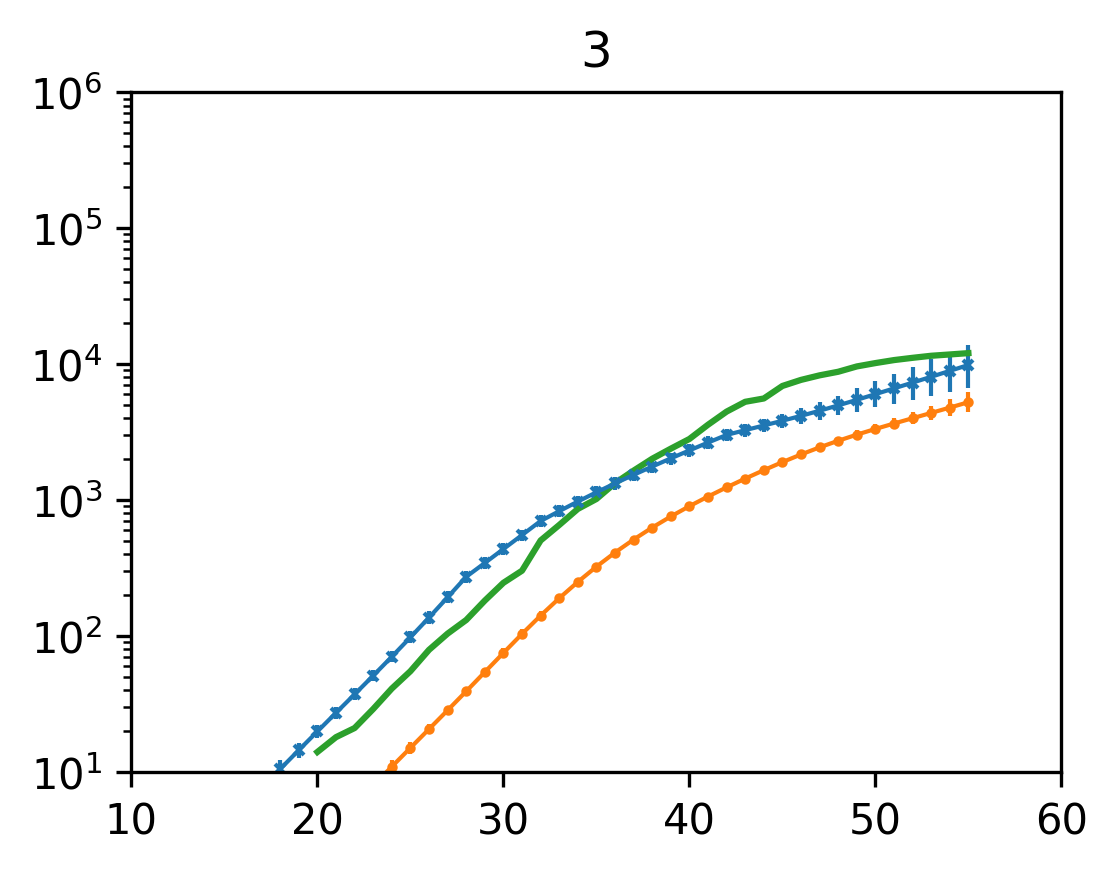

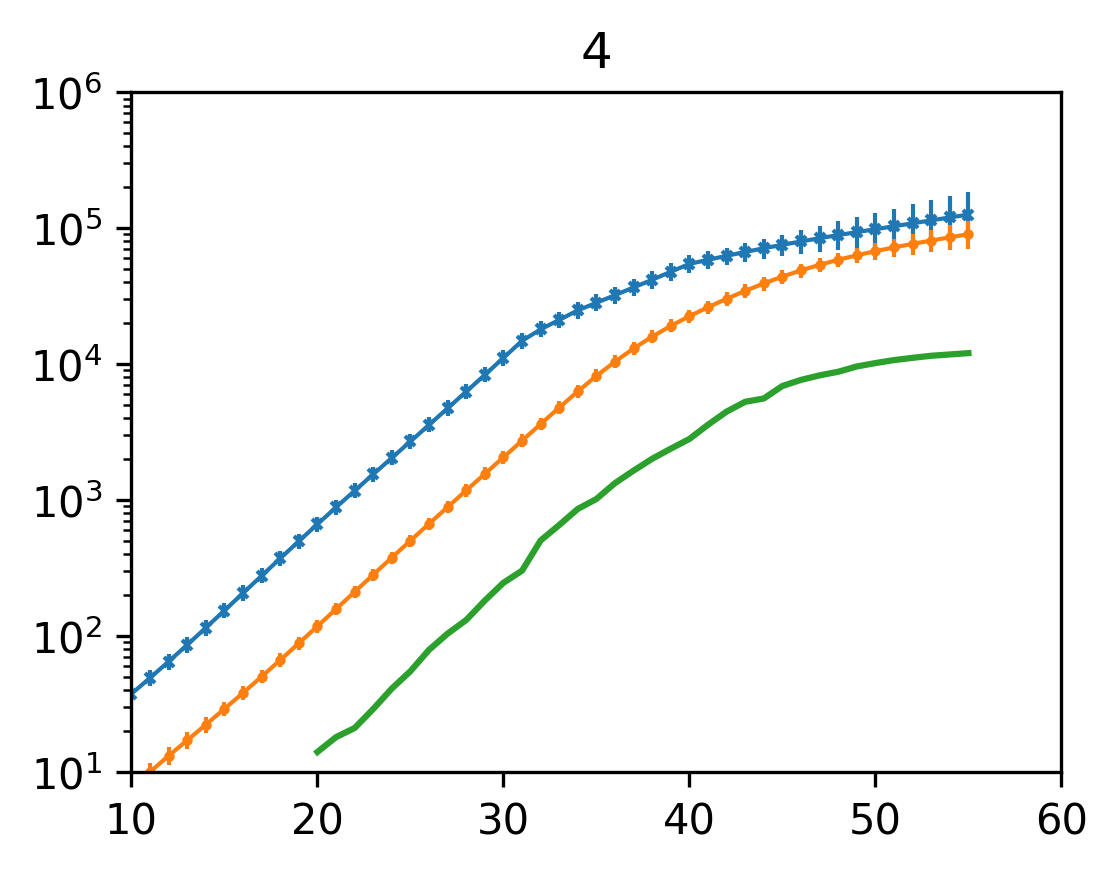

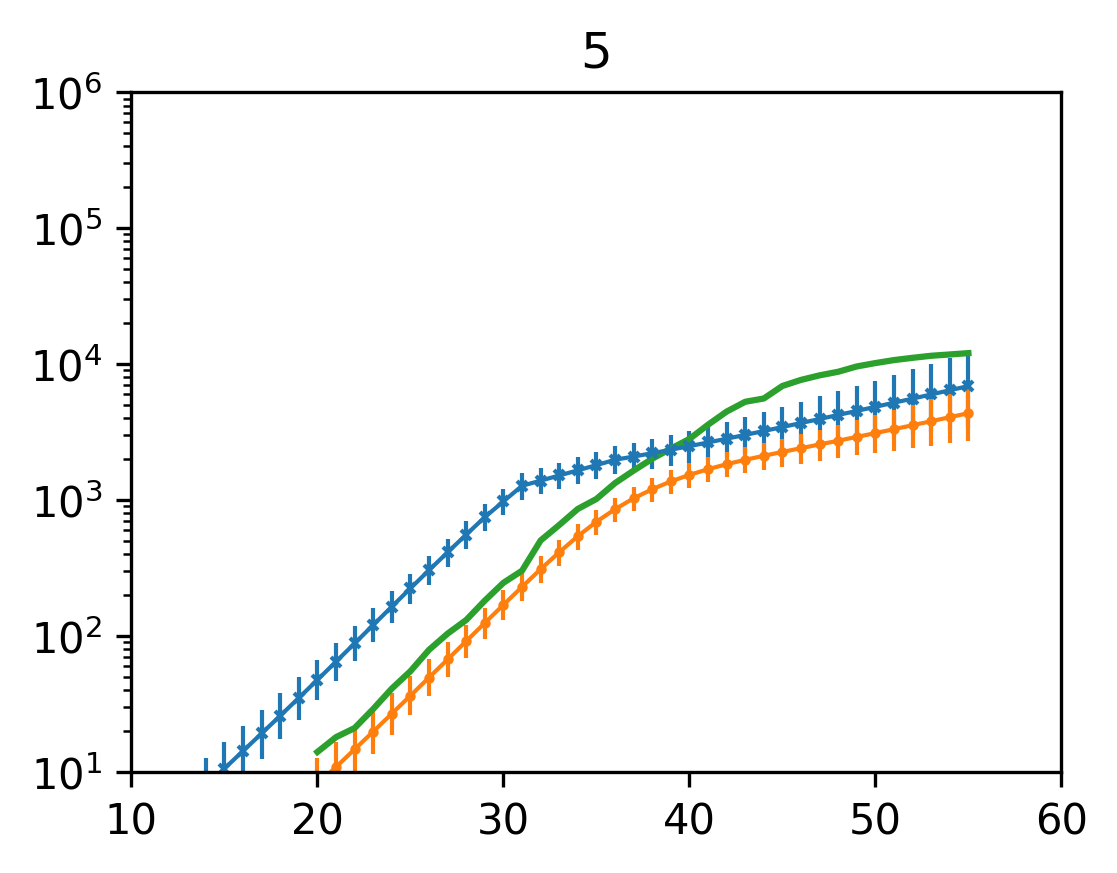

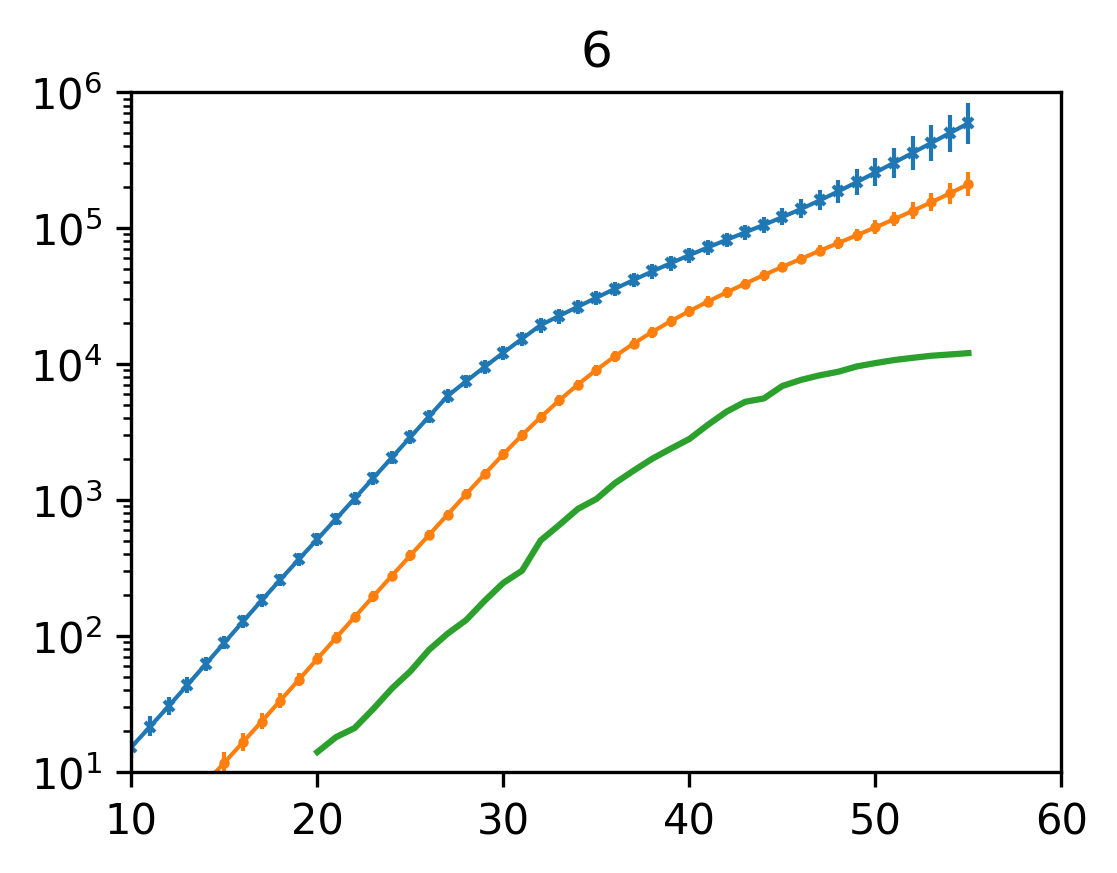

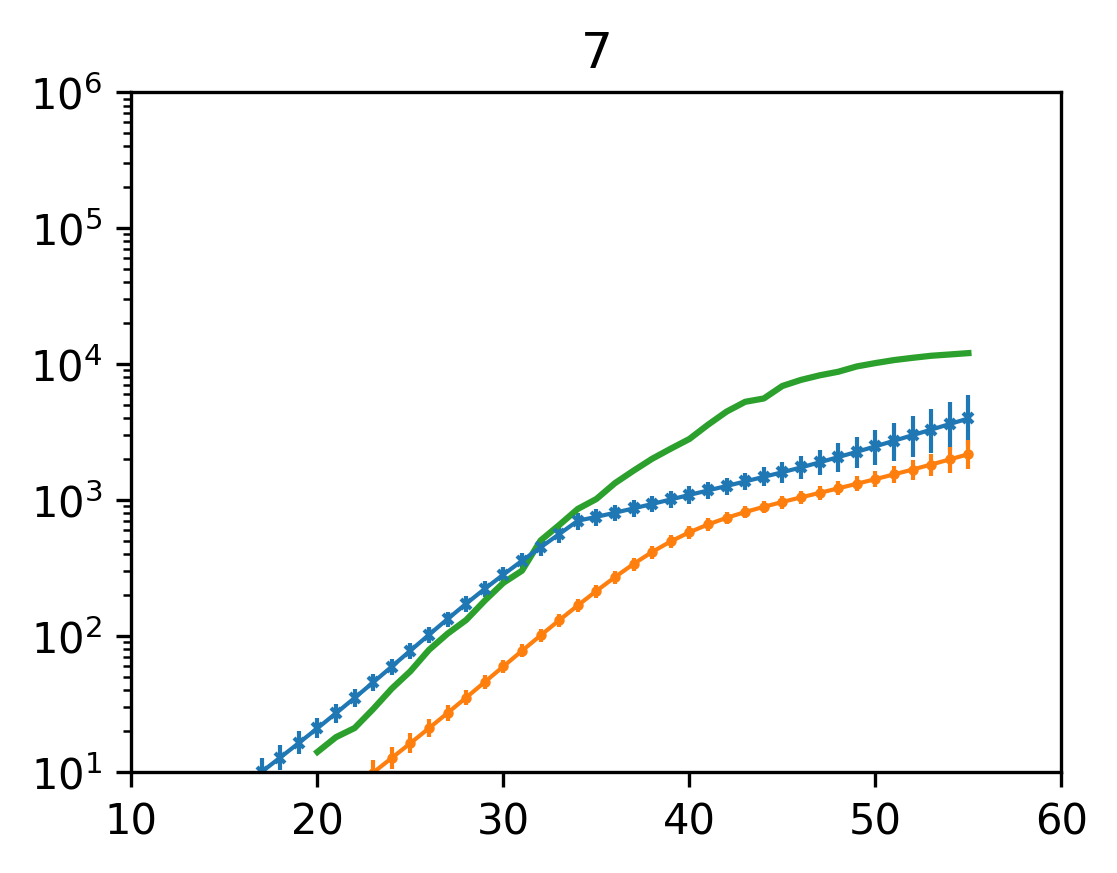

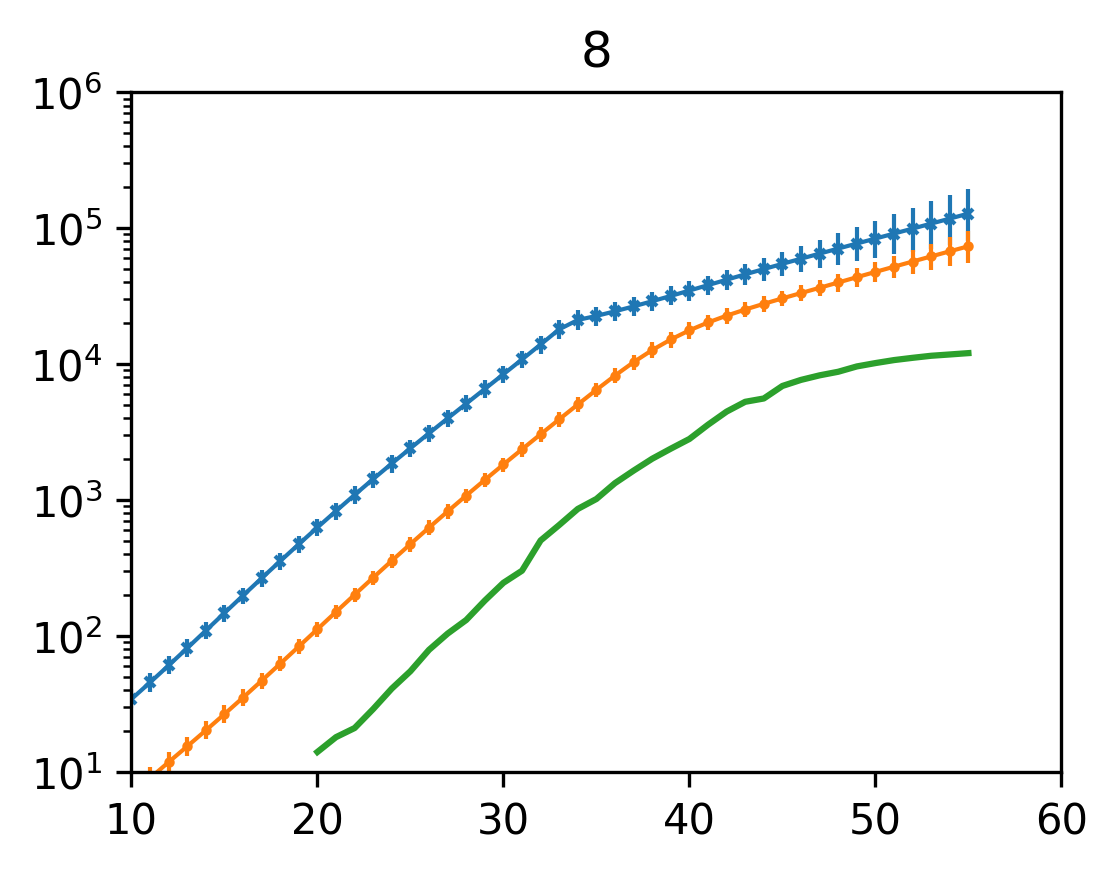

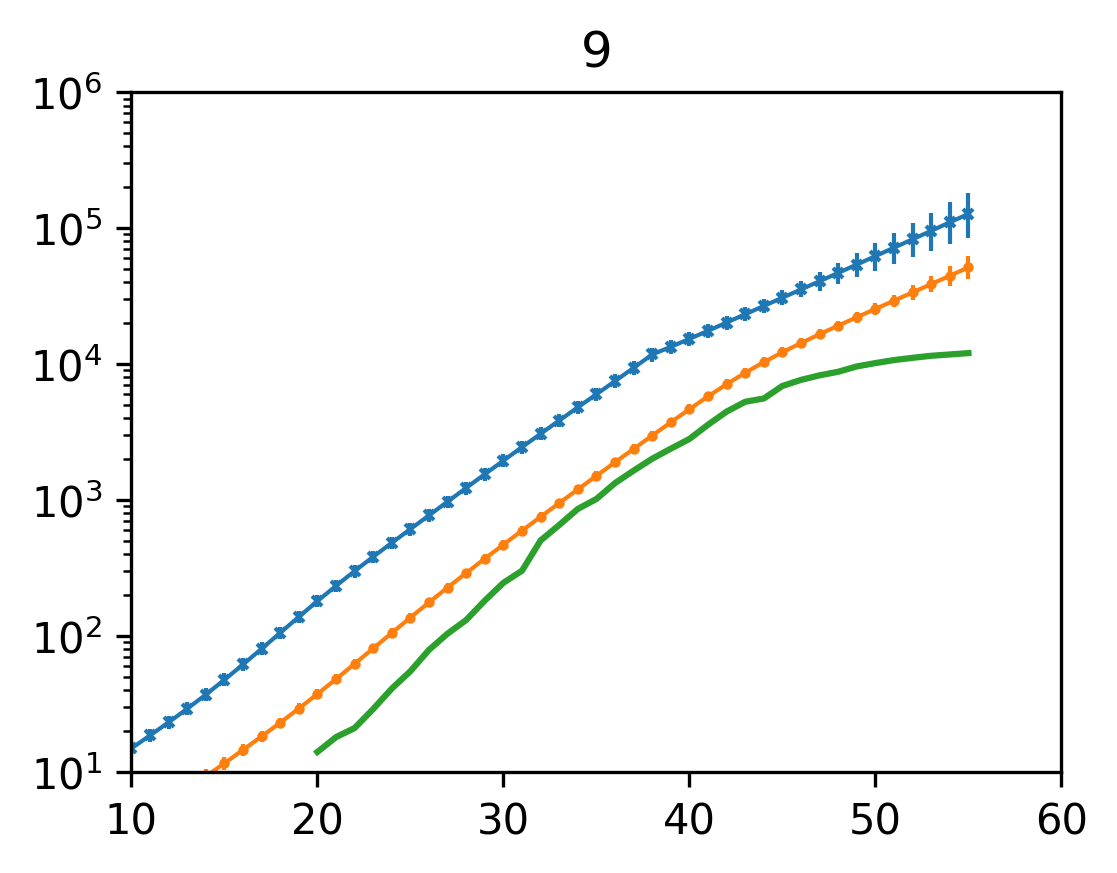

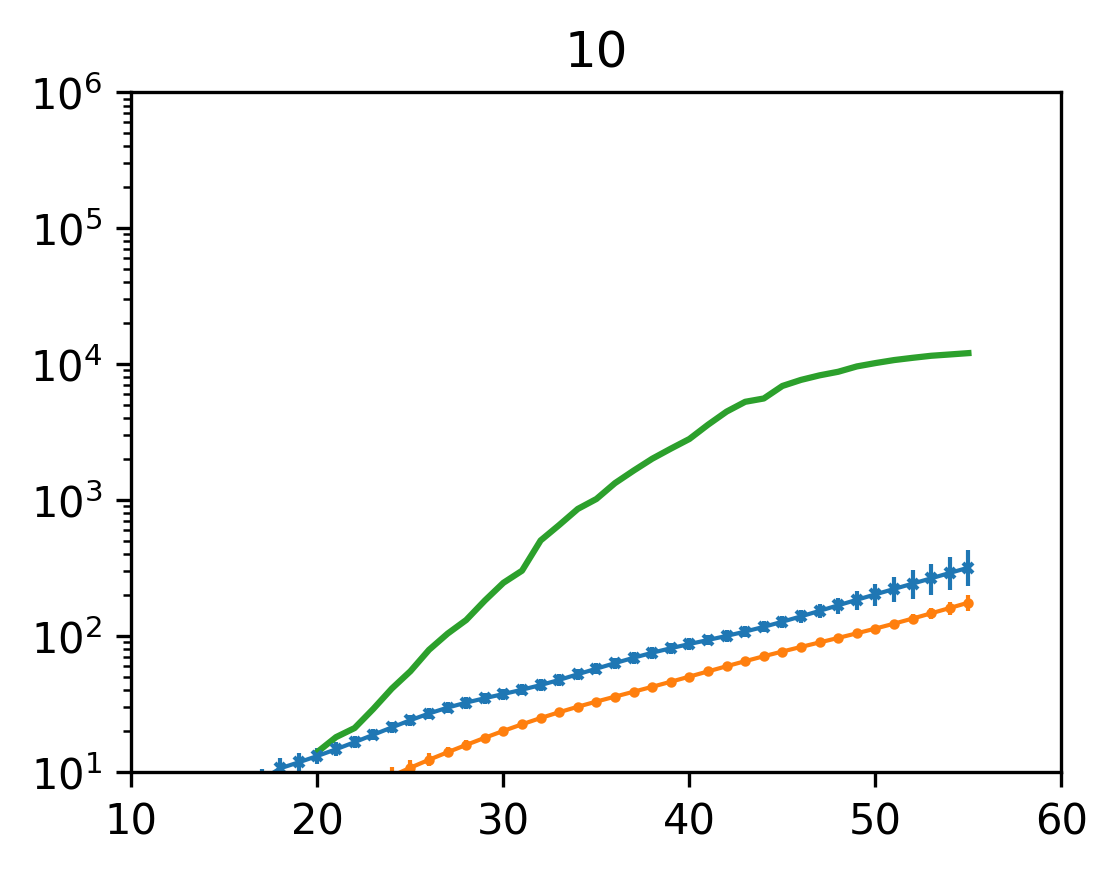

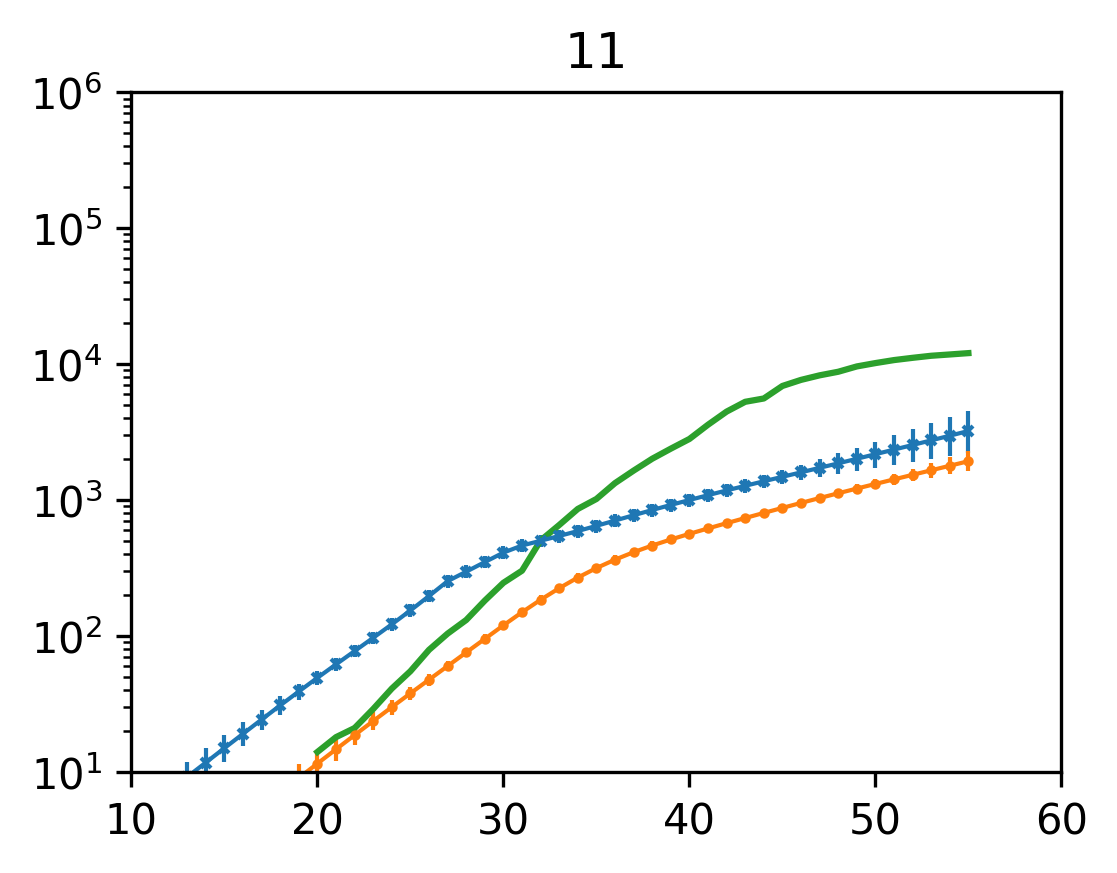

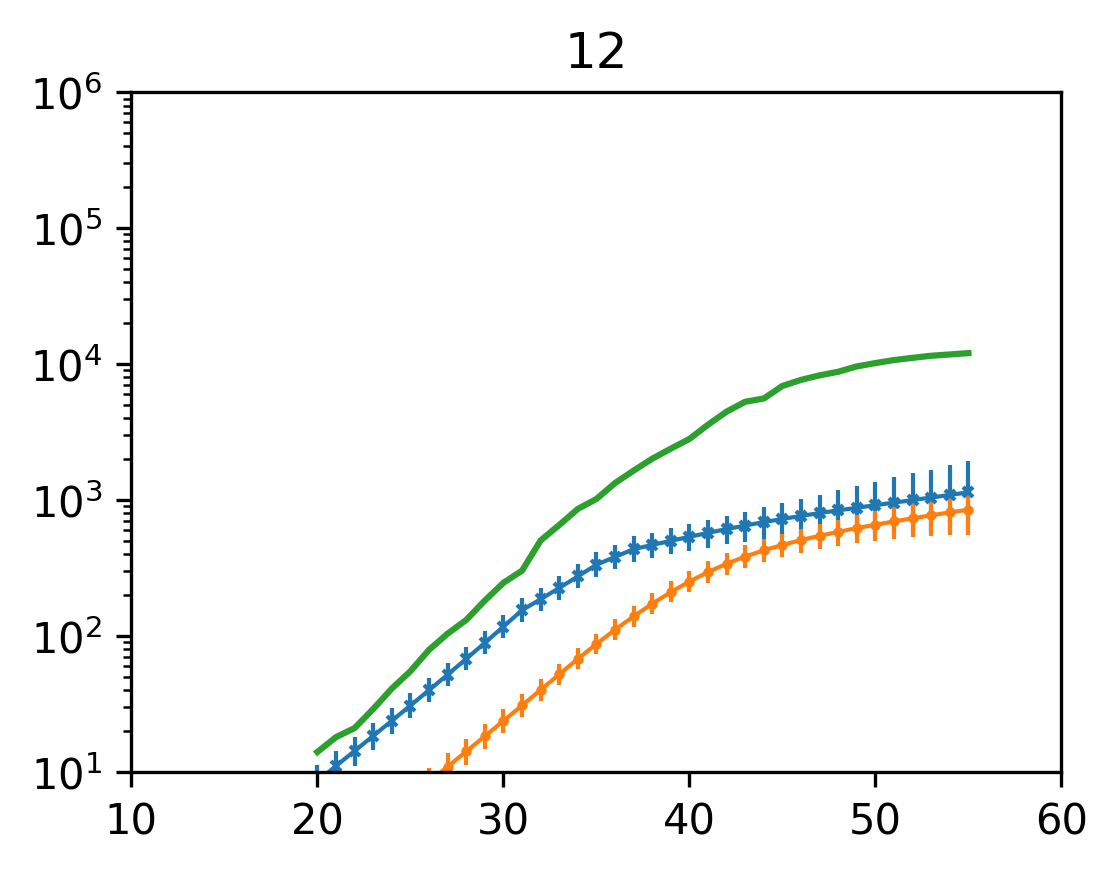

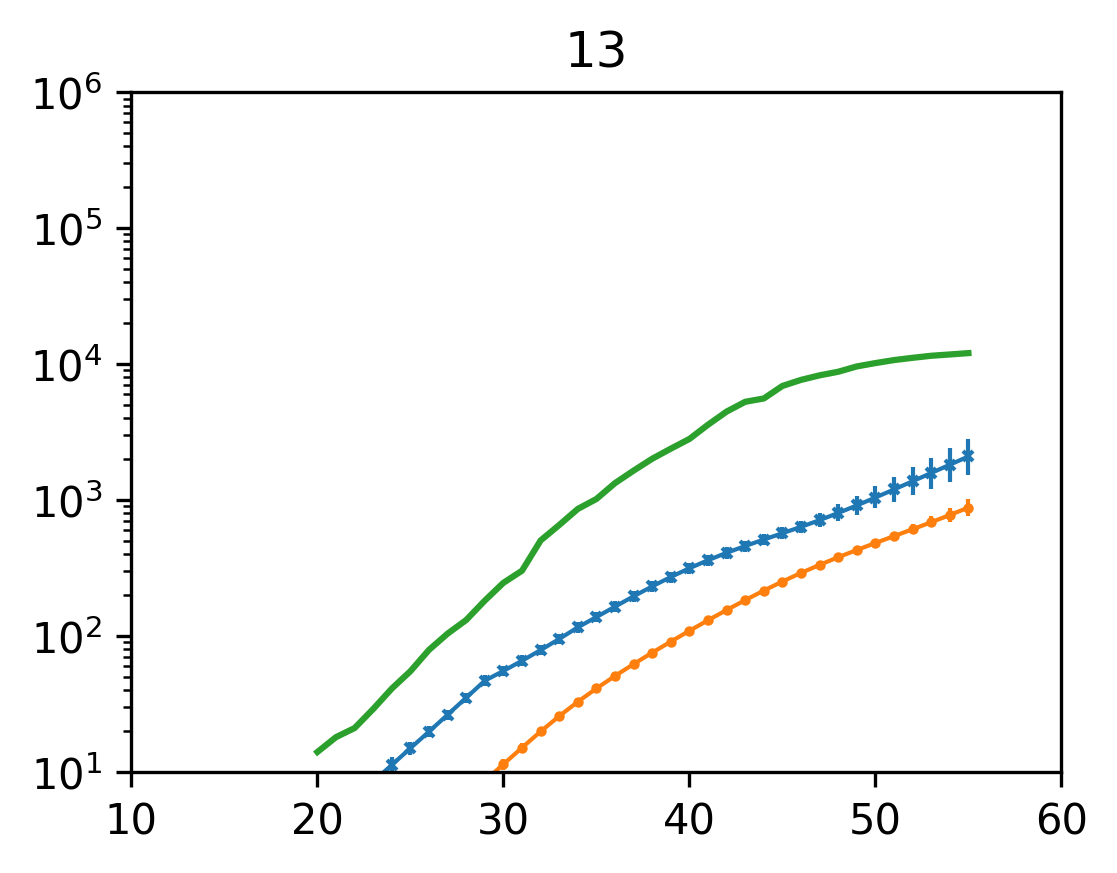

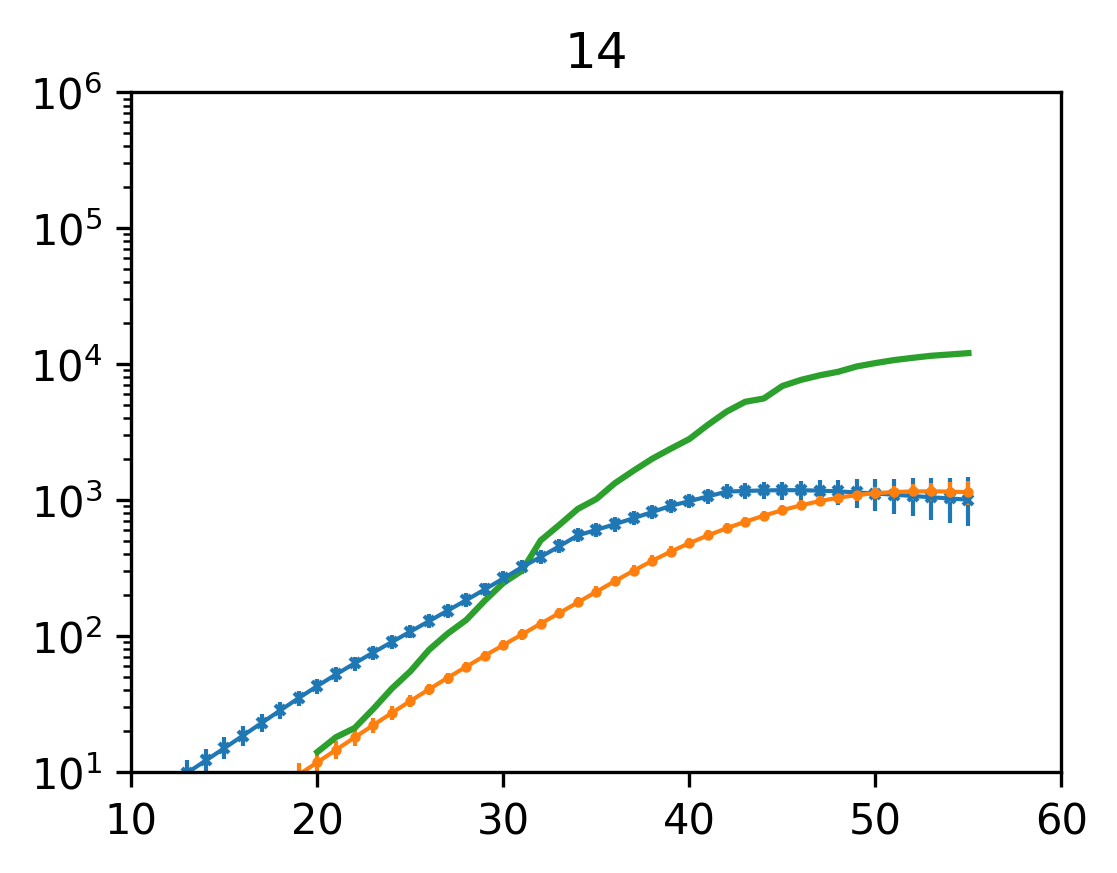

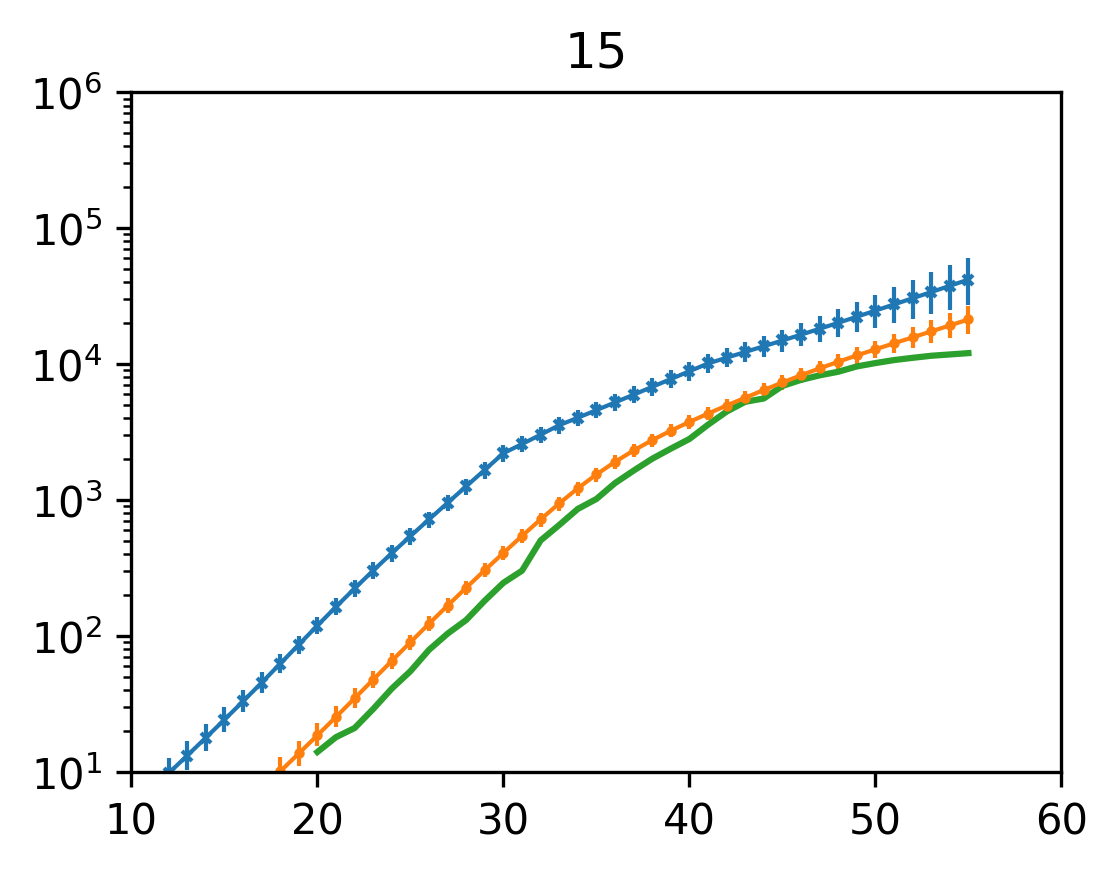

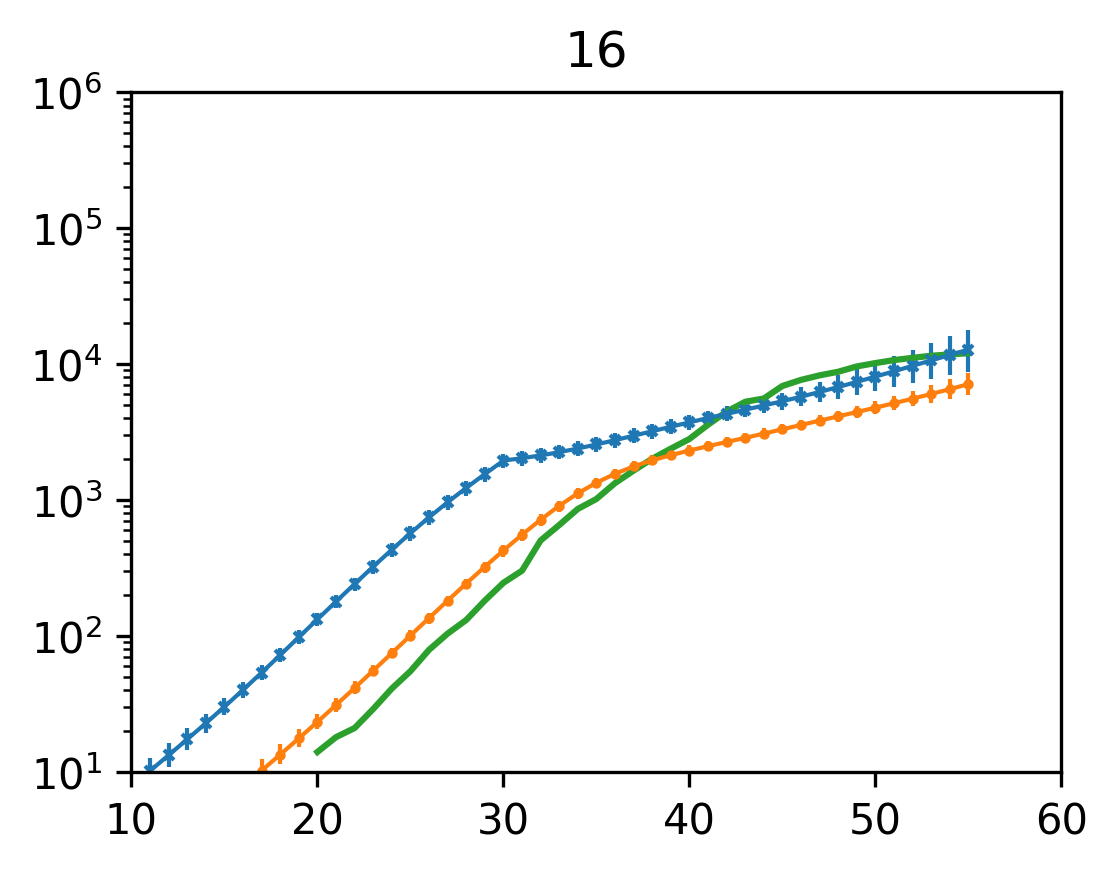

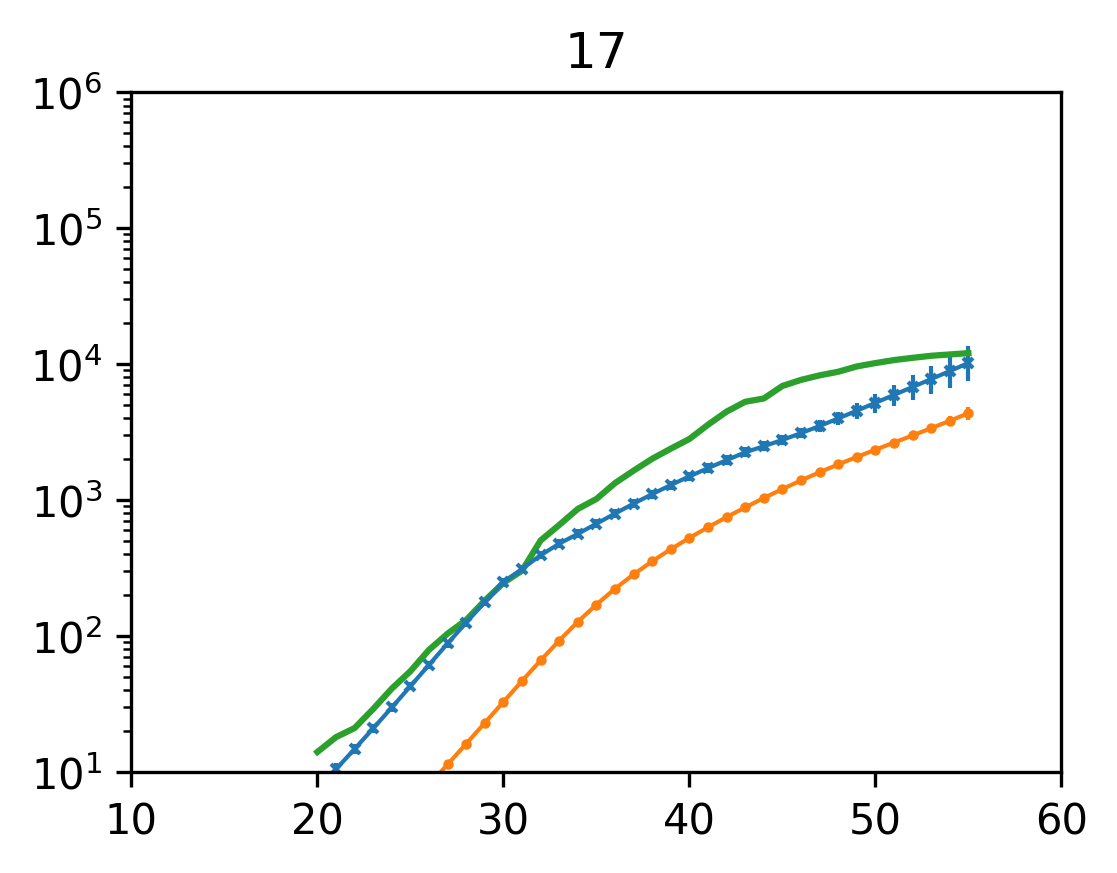

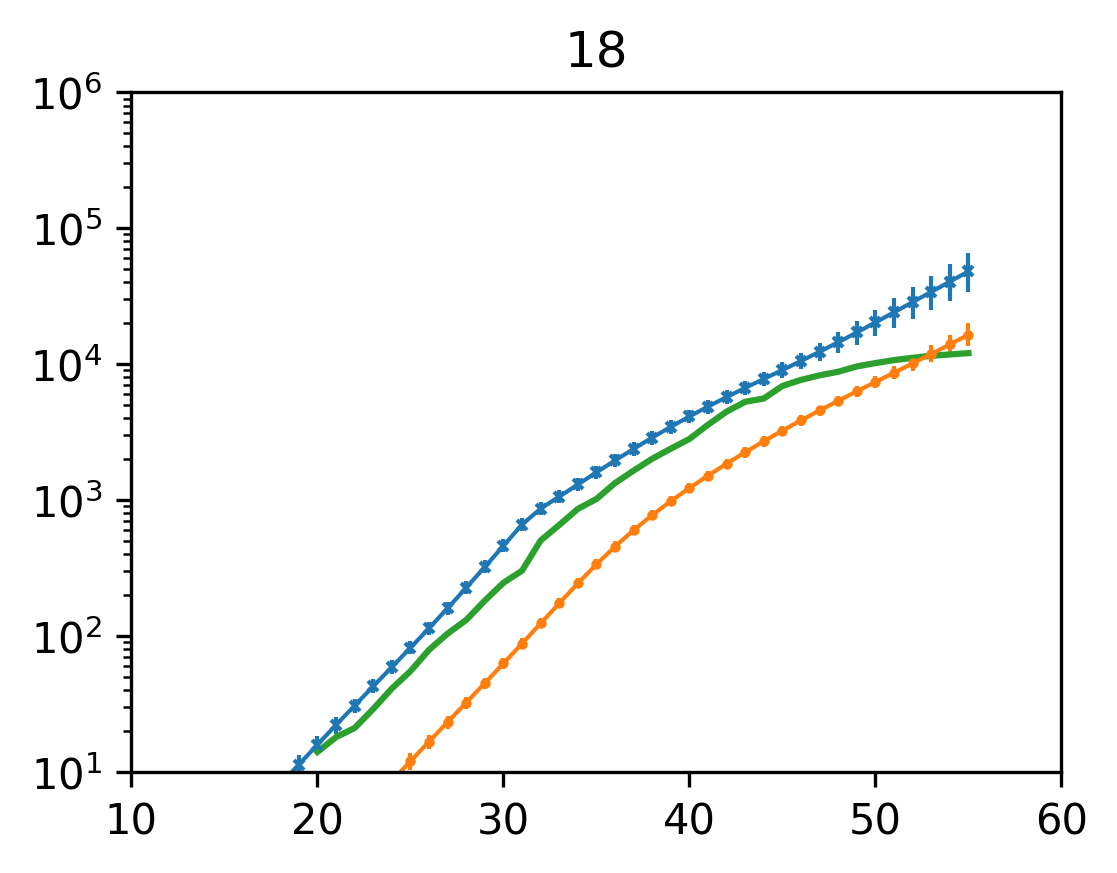

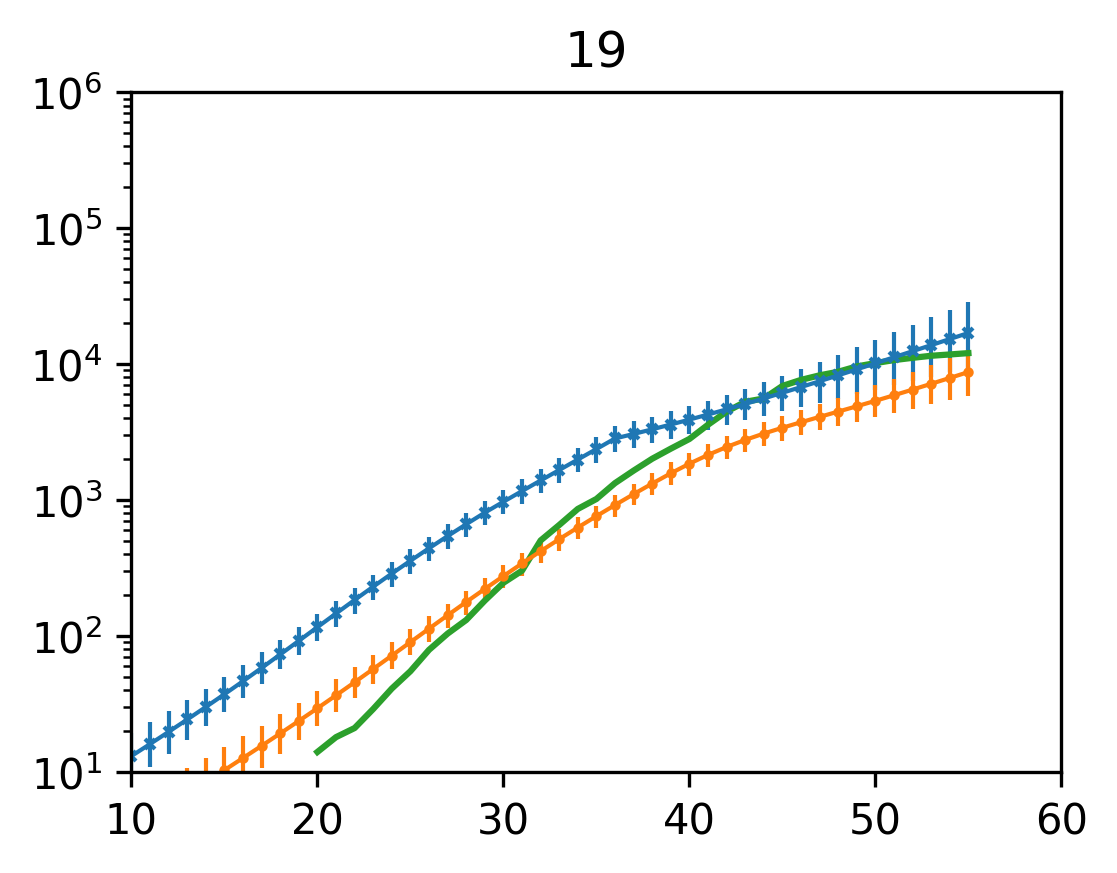

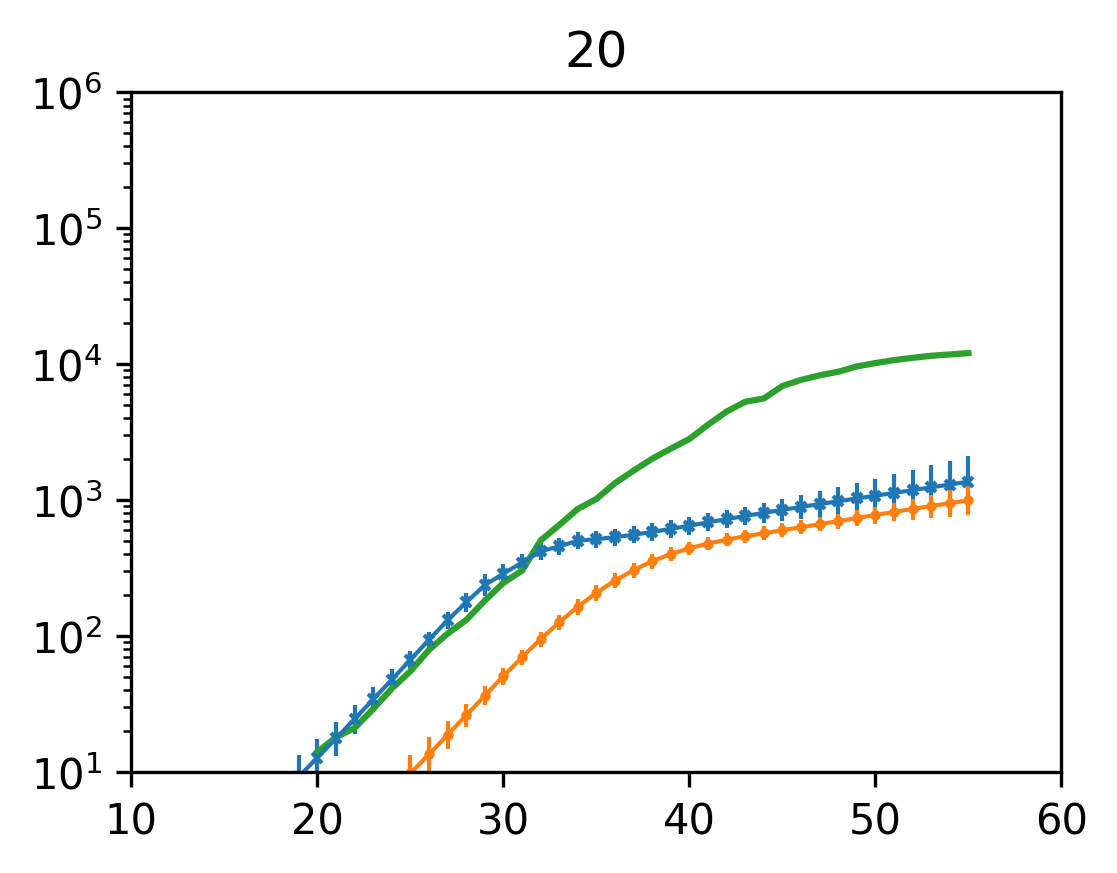

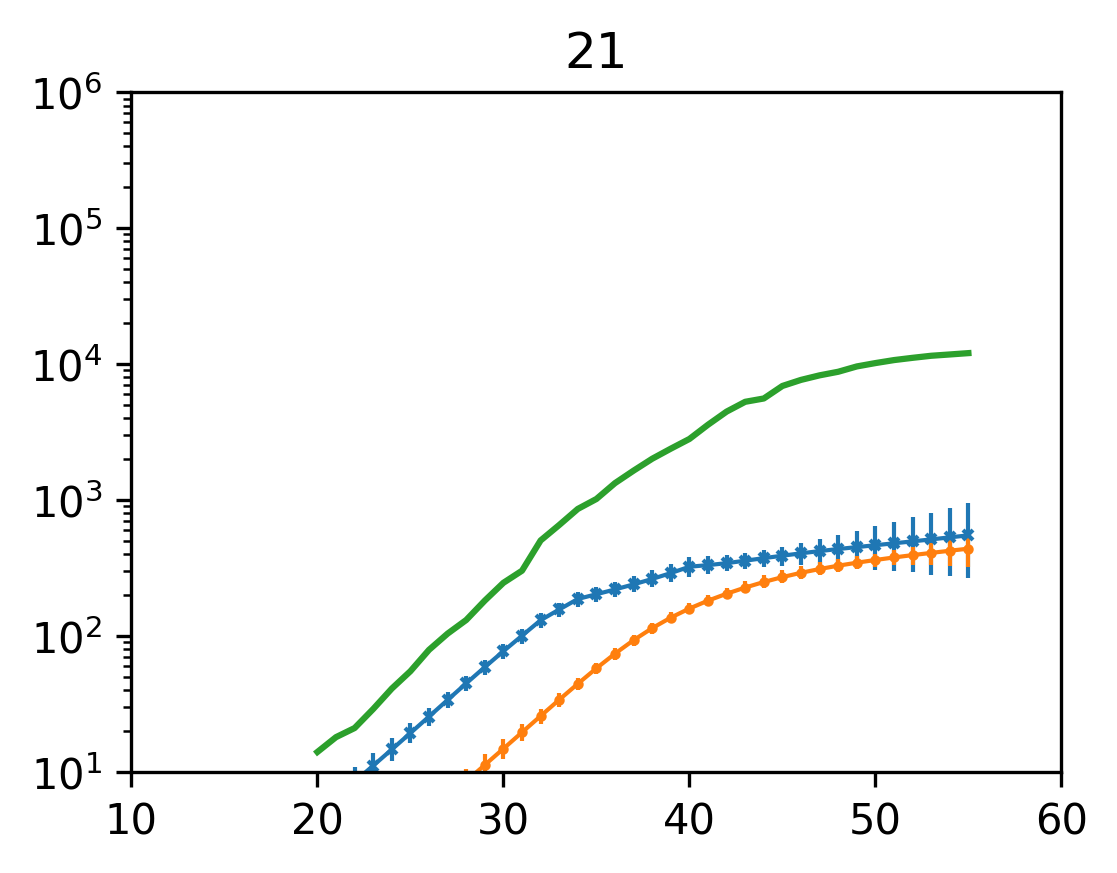

In [288]:
for country_indx in range(22):
    means = np.mean(model.trace.Infected[:, country_indx, :], axis=0)
    li = np.percentile(model.trace.Infected[:, country_indx, :], 2.5, axis=0)
    ui = np.percentile(model.trace.Infected[:, country_indx, :], 97.5, axis=0)
    err = np.array([means-li, ui-means])

    means_delayed = np.mean(model.trace.ExpectedConfirmed[:, country_indx, :], axis=0)
    li_delayed = np.percentile(model.trace.ExpectedConfirmed[:, country_indx, :], 2.5, axis=0)
    ui_delayed = np.percentile(model.trace.ExpectedConfirmed[:, country_indx, :], 97.5, axis=0)
    err_delayed = np.array([means_delayed-li_delayed, ui_delayed-means_delayed])

    labels = model.d.Confirmed[0, :]

    max_val = 10 ** np.ceil(np.log10(max(np.max(ui), np.max(labels))))
    min_val = 10 ** np.floor(np.log10(min(np.min(li), np.min(labels))))

    plt.figure(figsize=(4, 3), dpi=300)
    plt.errorbar(np.arange(56), means, yerr=err, fmt="-x", linewidth=1, markersize=2.5)
    plt.errorbar(np.arange(56), means_delayed, yerr=err_delayed, fmt="-o", linewidth=1, markersize=1.5)
    plt.plot(labels)
    ax = plt.gca()
    ax.set_yscale("log")
    plt.plot([0, 10 ** 6], [0, 10 ** 6], "-r")
    plt.xlim([10, 60]);
    plt.ylim([10, 10**6])
    plt.title(country_indx)

In [289]:
model.trace.varnames

['CMReduction_log__',
 'RegionGrowthRate_log__',
 'RegionNoiseScale_log__',
 'Growth',
 'InitialSize_log__',
 'Observed_missing',
 'HeldoutDaysObserved_log__',
 'CMReduction',
 'RegionGrowthRate',
 'RegionNoiseScale',
 'GrowthReduction',
 'InitialSize',
 'Infected',
 'ExpectedConfirmed',
 'HeldoutDaysObserved']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x157c5a5d0>,
      dtype=object)

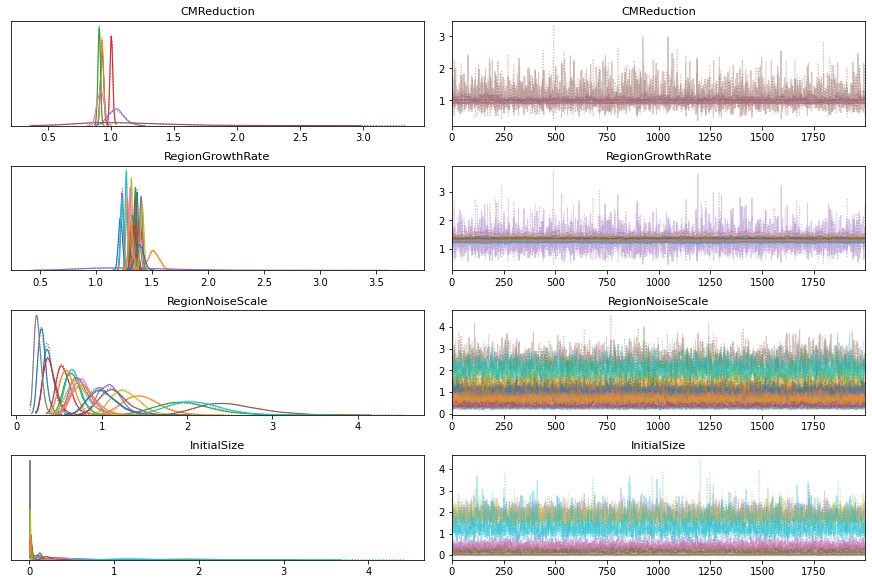

In [290]:
model.plot_traces()

# fixing the confirmed noise across all countries

INFO:epimodel.regions:Name index has 6 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands']
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:
Countermeasures                               min   .. mean  .. max
 0 Gatherings limited to                      0.000 .. 0.177 .. 0.982
 1 Business suspended                         0.000 .. 0.273 .. 1.000
 2 Schools and universities closed            0.000 .. 0.361 .. 1.000
 3 General curfew                             0.000 .. 0.167 .. 1.000
 4 Healthcare specialisation                  0.000 .. 0.020 .. 0.429
 5 Phone line                                 0.000 .. 0.032 .. 1.000
 6 Asymptomatic contact isolation             0.000 .. 0.053 .. 1.000


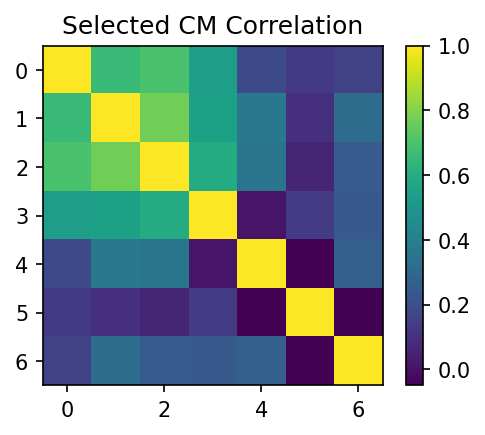

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Data Preprocessing Complete using:

{
    "start_date": "2020-2-10",
    "end_date": "2020-04-05",
    "min_final_num_active_cases": 100,
    "min_num_active_mask": 10,
    "min_num_confirmed_mask": 10
}
/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in Observed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [318]:
regions = ["PT", "IS", "HU", "HR", "BE", "NL", "DK", "DE", "AT", "CZ", "GE", "FR", "ES", "GB", "PL", "GR", "CH", "FI", "NO", "SE", "SI", "SK"]
features = ['Gatherings limited to', 'Business suspended', 'Schools and universities closed', 'General curfew',
       'Healthcare specialisation', 'Phone line', 'Asymptomatic contact isolation']

dp = DataPreprocessor()
data = dp.preprocess_data("../../data", regions, features)

# 0.075 growth noise, scaled. then 0.3 fixed confirmation noise
with cm_effect.models.CMModelFlexibleV3(data, heldout_days=[53, 54, 55]) as model:
    model.build_cm_reduction_prior()
    model.build_region_growth_prior()
    model.build_region_reliability_prior(pm.Normal, {"mu": 1, "sigma": 0.05})
    model.build_rates()
    model.build_output_model()

In [319]:
model.run(2000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...


CMReduction_log__               -1.58
RegionGrowthRate_log__          -0.06
RegionNoiseScale                45.69
Growth_log__                  2059.08
InitialSize_log__              -70.87
Observed_missing                 0.00
HeldoutDaysObserved_log__       18.81
Observed                    -15711.22
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [HeldoutDaysObserved, Observed_missing, InitialSize, Growth, RegionNoiseScale, RegionGrowthRate, CMReduction]
INFO:pymc3:NUTS: [HeldoutDaysObserved, Observed_missing, InitialSize, Growth, RegionNoiseScale, RegionGrowthRate, CMReduction]
Sampling 2 chains, 46 divergences: 100%|██████████| 5000/5000 [14:21<00:00,  5.80draws/s]
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8919921644778045, but should be close to 0.8. Try to increase the number of tuning steps.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It i

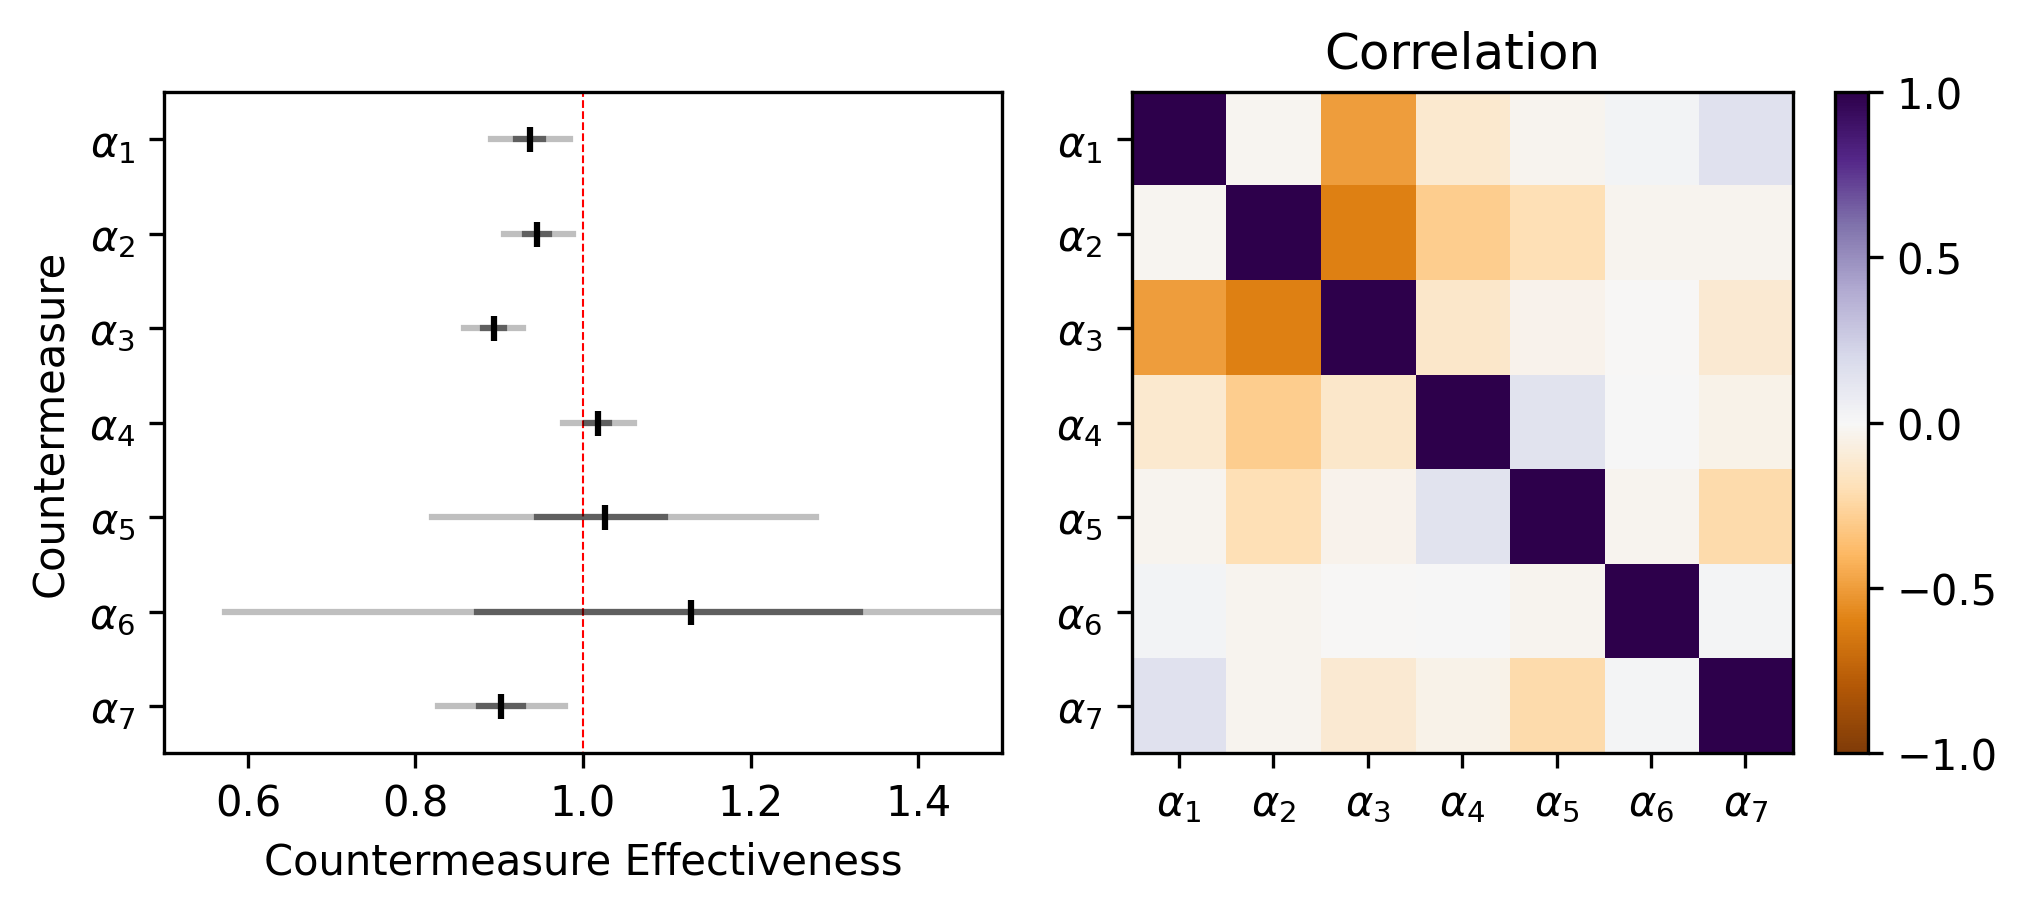

In [320]:
model.plot_effect()

INFO:epimodel.pymc3_models.cm_effect.models:Saving Day Validation Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/heldout_validation/out
INFO:epimodel.pymc3_models.cm_effect.models:Saving Day Validation Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/heldout_validation/out
INFO:epimodel.pymc3_models.cm_effect.models:Saving Day Validation Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/heldout_validation/out


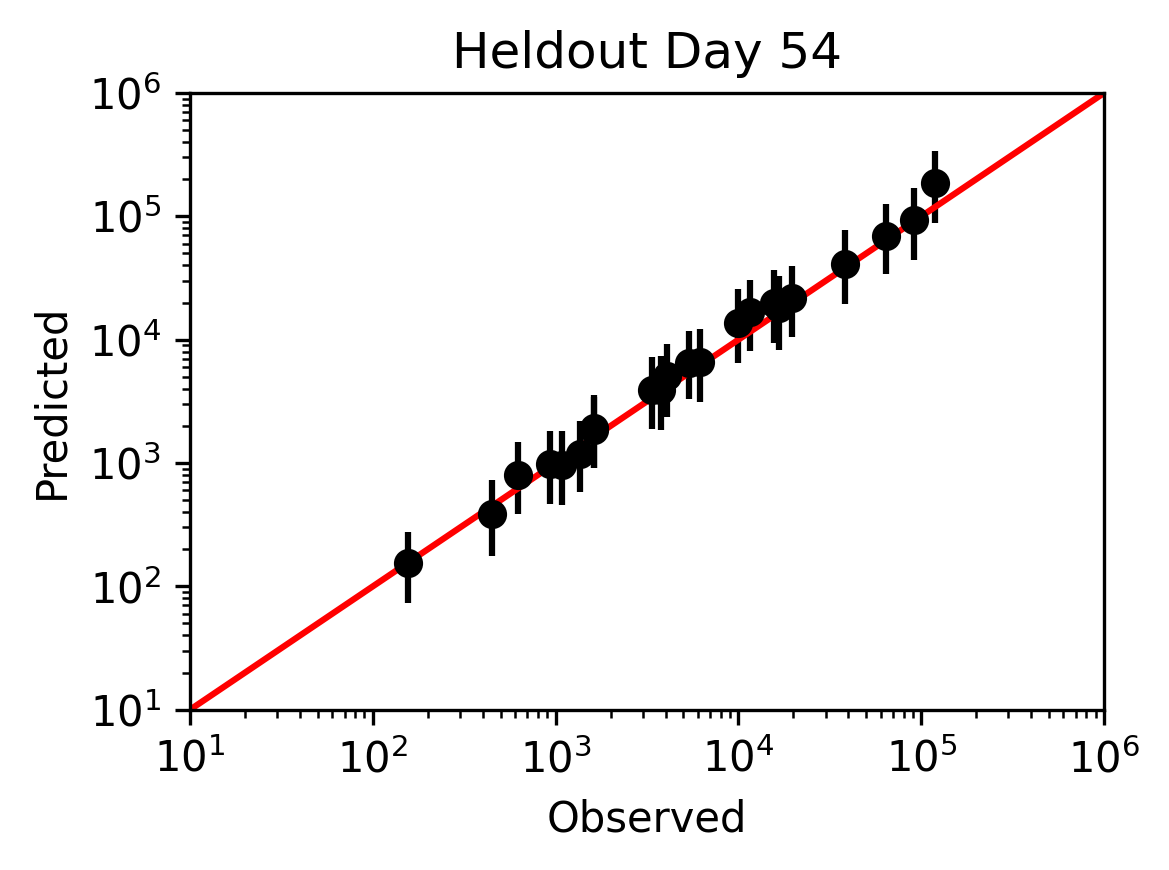

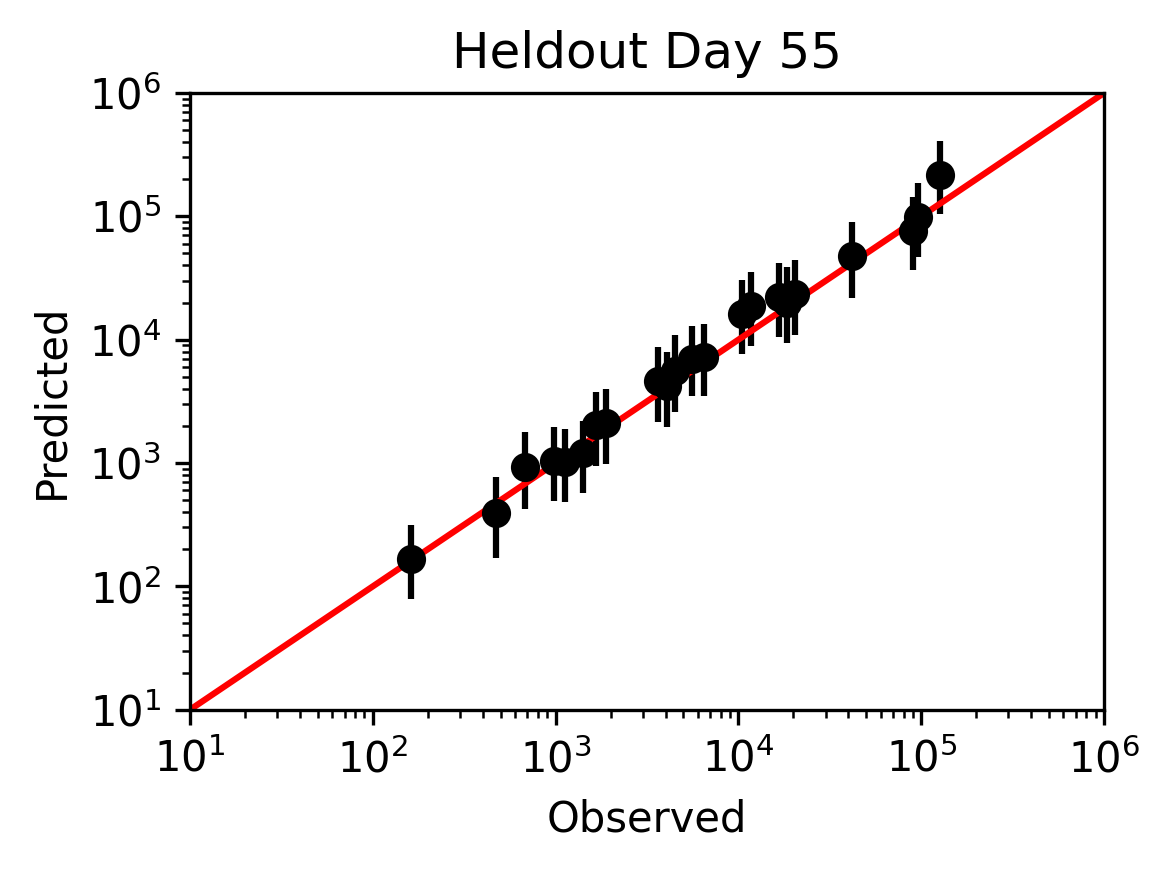

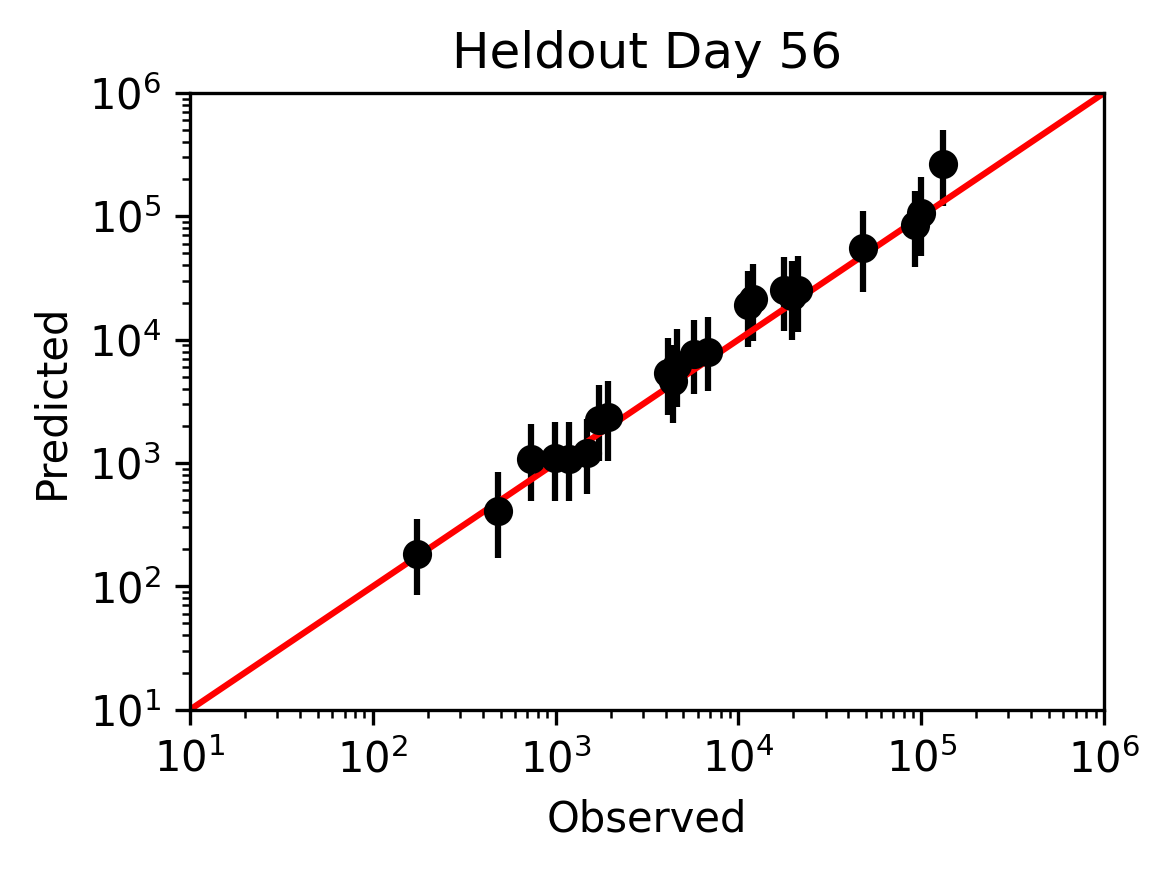

In [321]:
model.heldout_days_validation_plot()

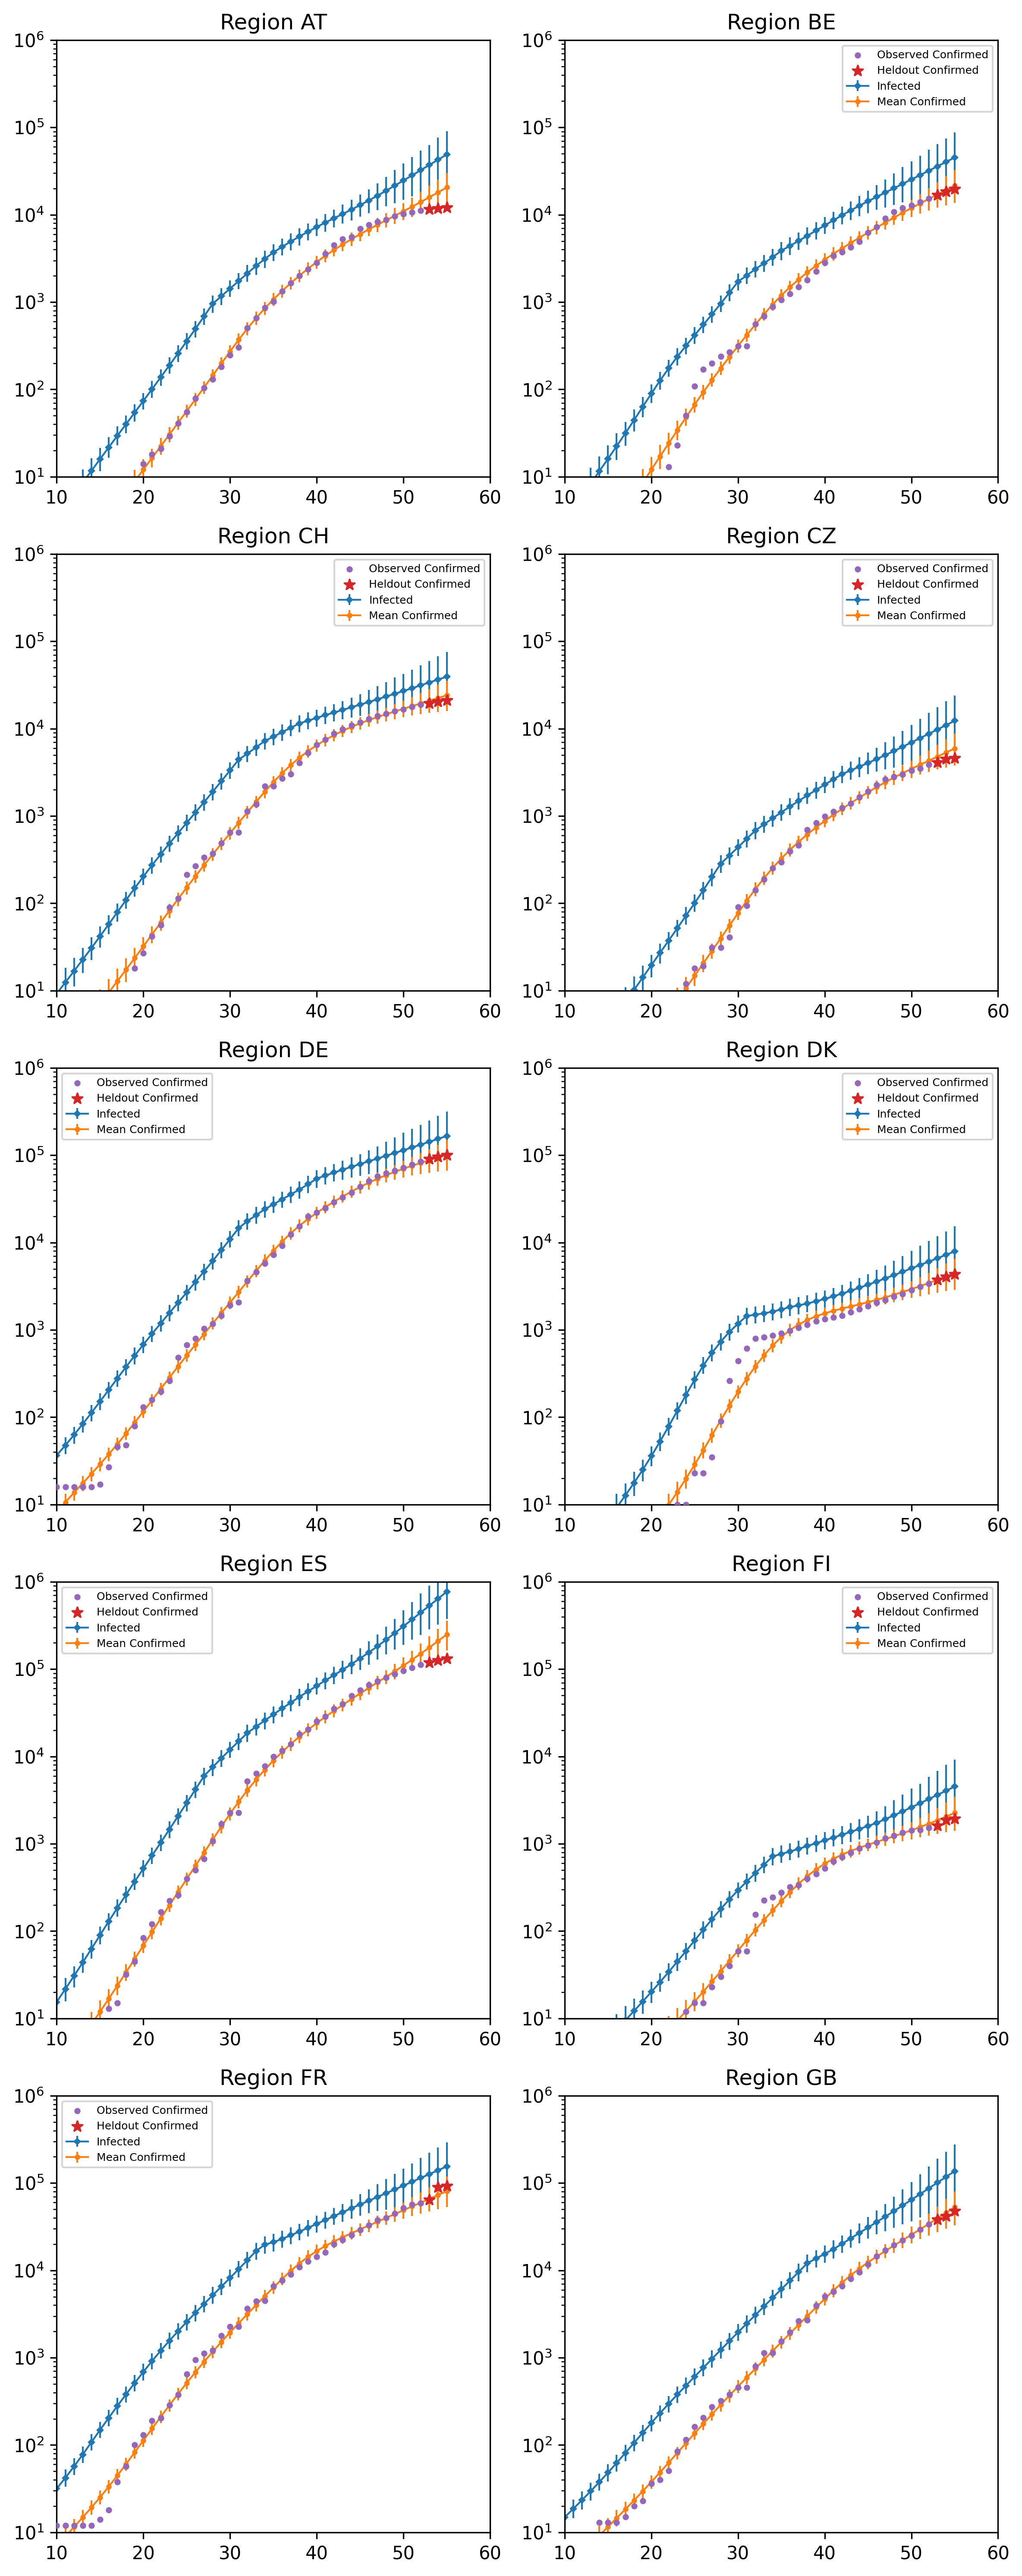

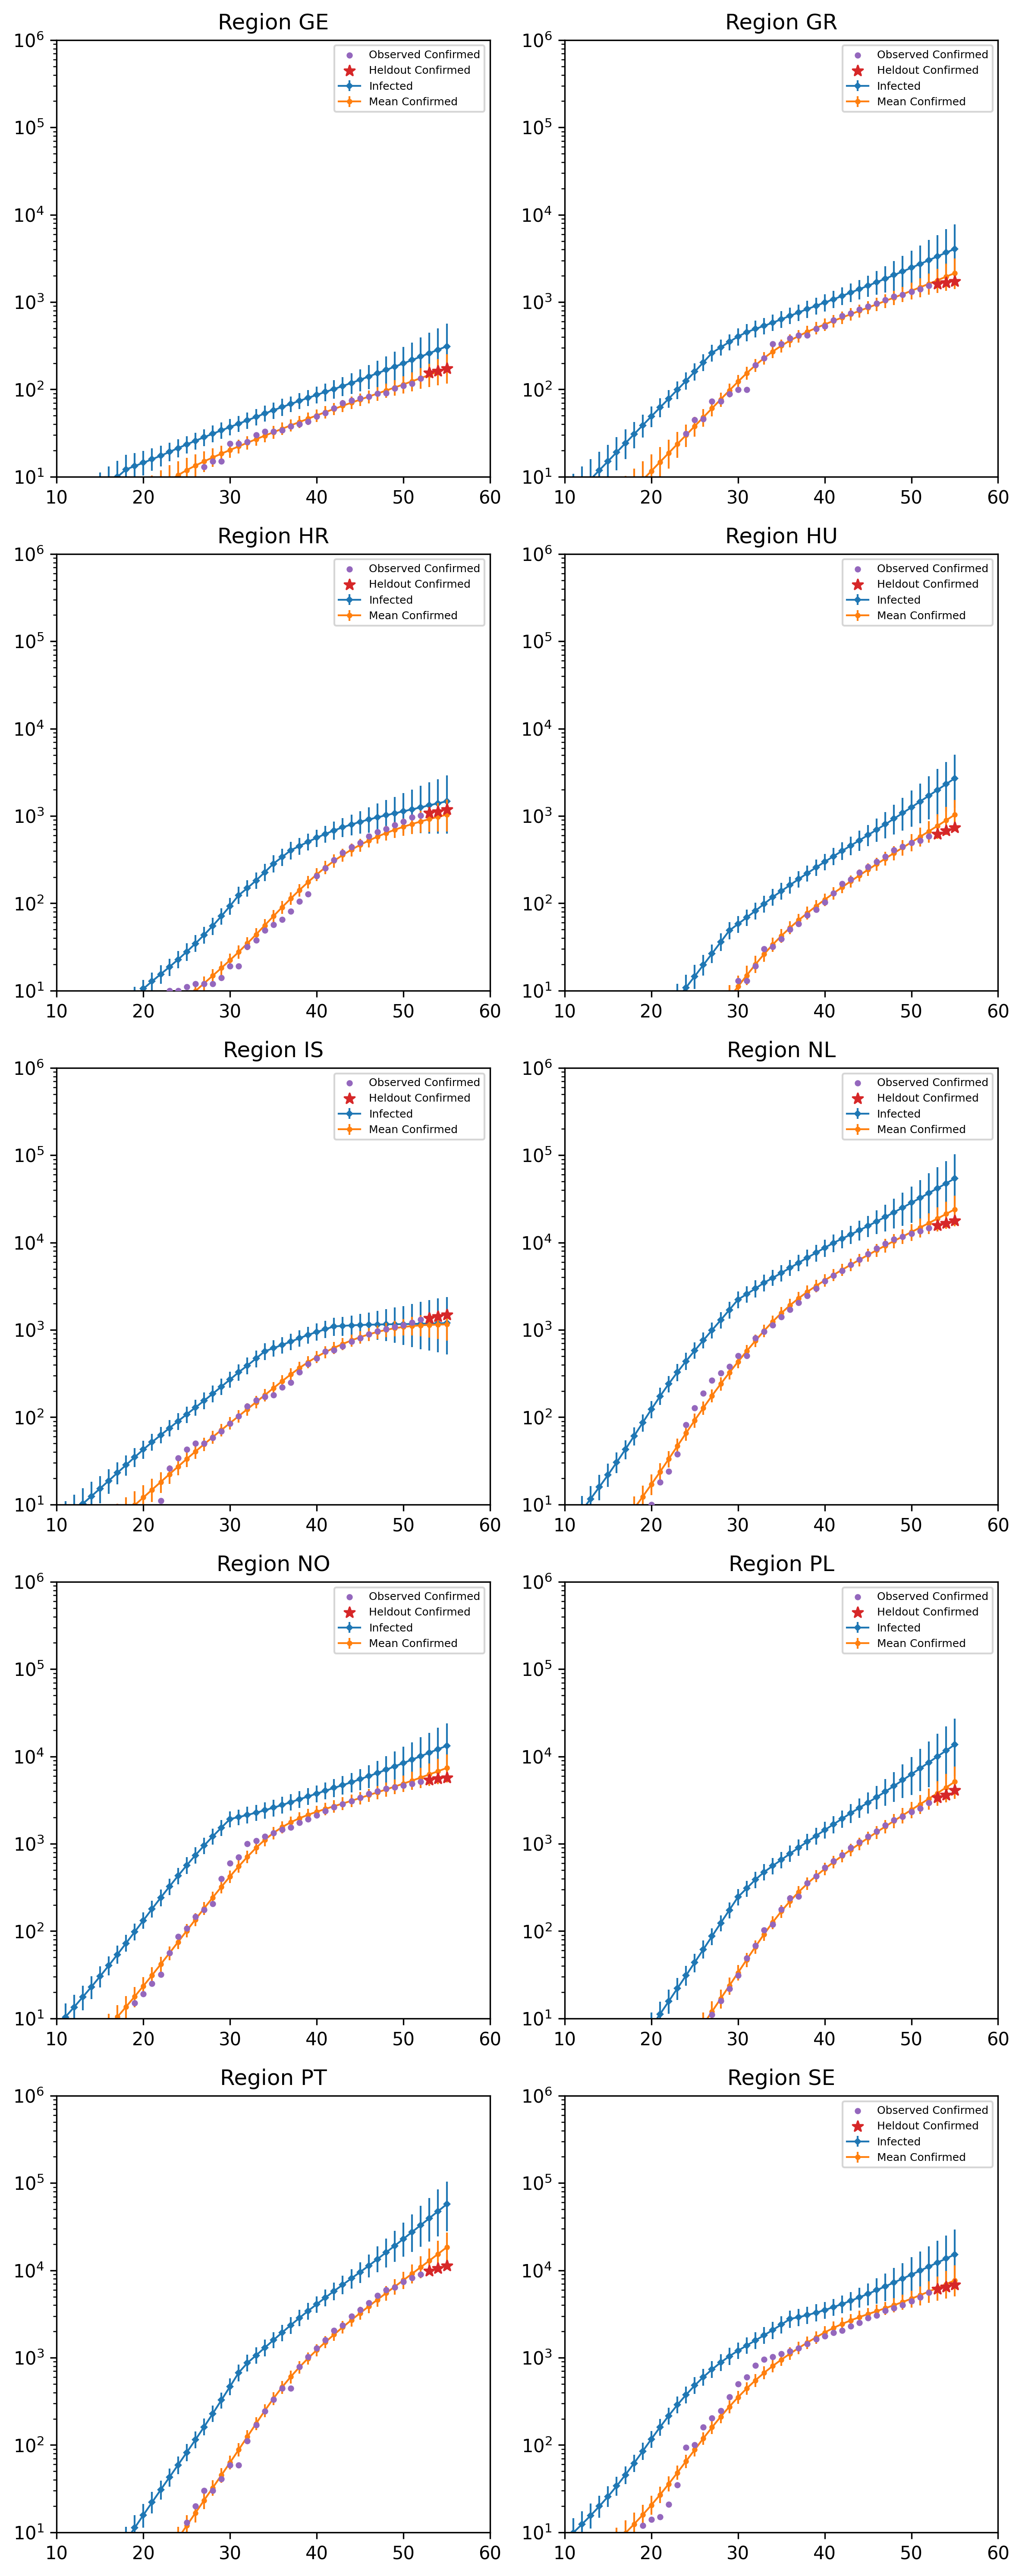

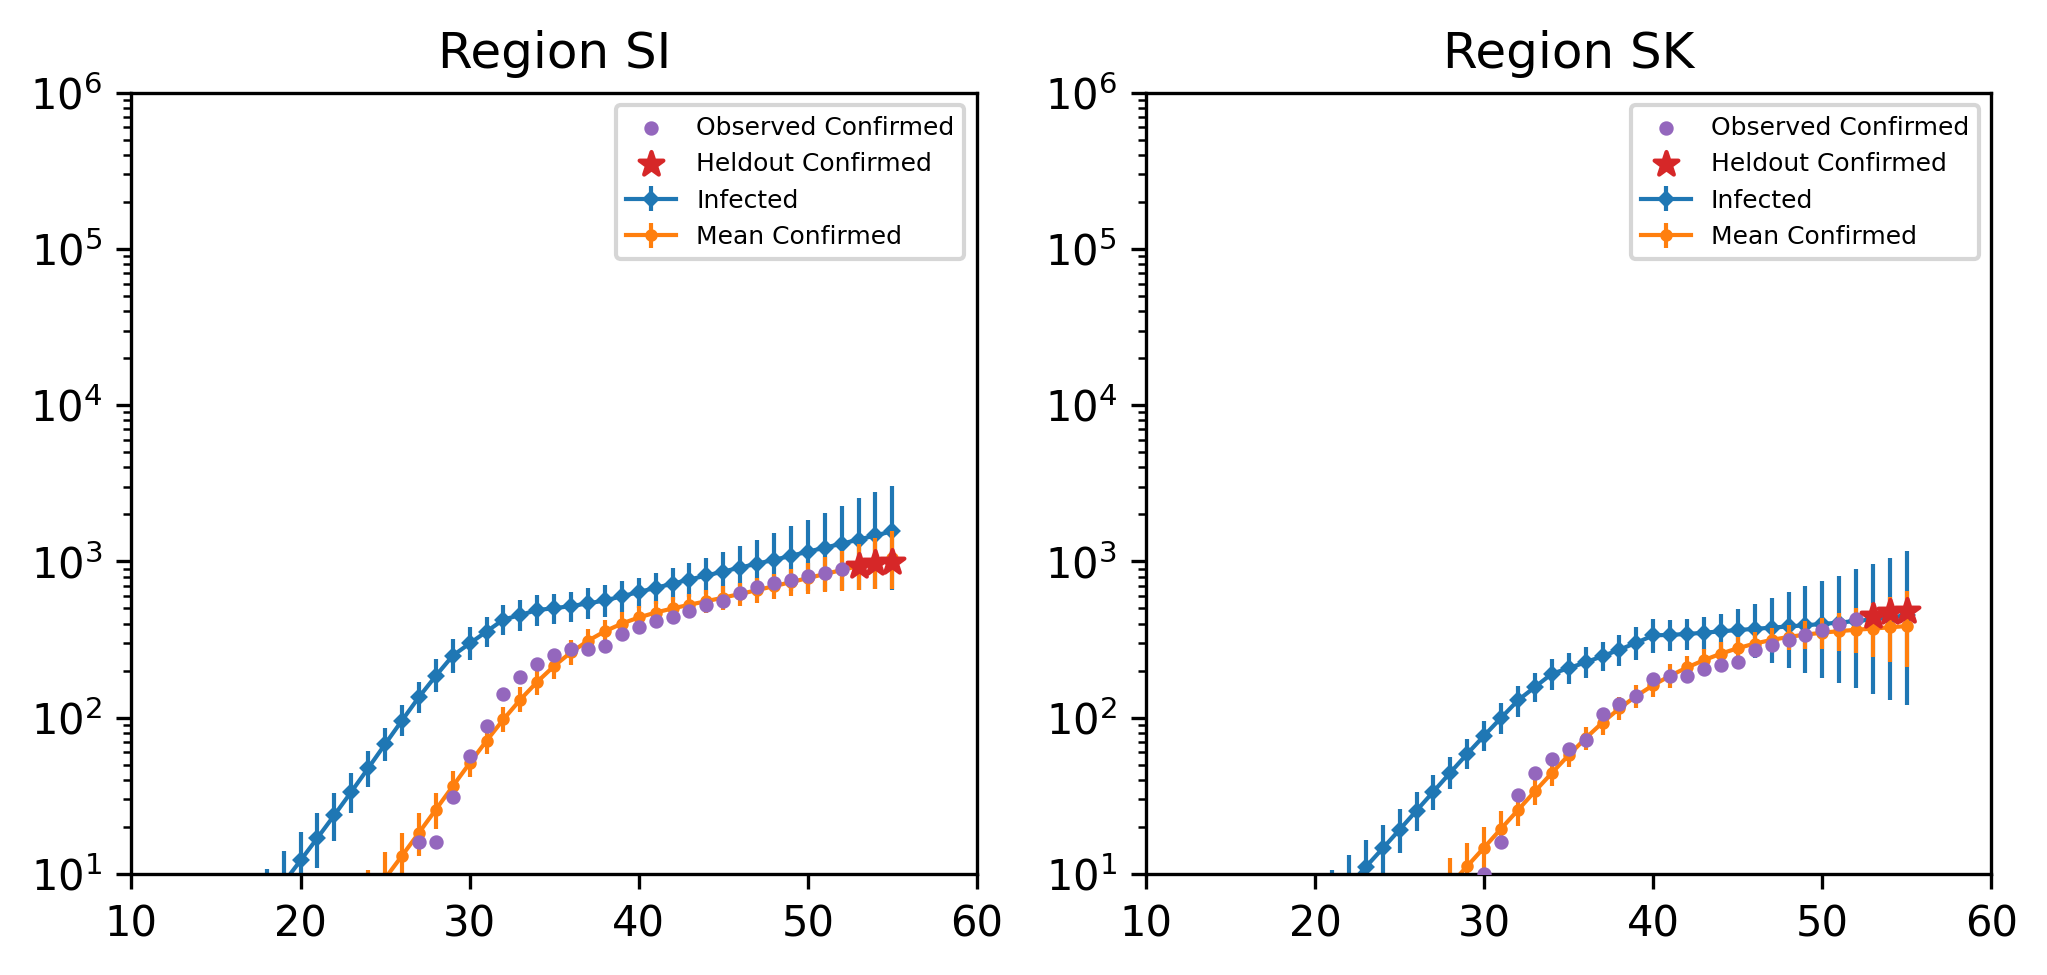

In [342]:
for country_indx in range(22):
    if country_indx % 10 == 0:
        plt.figure(figsize=(8, 20), dpi=300) 
    
    plt.subplot(5,2, country_indx % 10 + 1)
    means = np.mean(model.trace.Infected[:, country_indx, :], axis=0)
    li = np.percentile(model.trace.Infected[:, country_indx, :], 2.5, axis=0)
    ui = np.percentile(model.trace.Infected[:, country_indx, :], 97.5, axis=0)
    err = np.array([means-li, ui-means])

    means_delayed = np.mean(model.trace.ExpectedConfirmed[:, country_indx, :], axis=0)
    li_delayed = np.percentile(model.trace.ExpectedConfirmed[:, country_indx, :], 2.5, axis=0)
    ui_delayed = np.percentile(model.trace.ExpectedConfirmed[:, country_indx, :], 97.5, axis=0)
    err_delayed = np.array([means_delayed-li_delayed, ui_delayed-means_delayed])
    
    means_ho = np.mean(model.trace.HeldoutDaysObserved[:, country_indx, :], axis=0)
    li_ho = np.percentile(model.trace.HeldoutDaysObserved[:, country_indx, :], 2.5, axis=0)
    ui_ho = np.percentile(model.trace.HeldoutDaysObserved[:, country_indx, :], 97.5, axis=0)
    err_ho = np.array([means_ho-li_ho, ui_ho-means_ho])

    labels = model.d.Confirmed[country_indx, :]

    max_val = 10 ** np.ceil(np.log10(max(np.max(ui), np.max(labels))))
    min_val = 10 ** np.floor(np.log10(min(np.min(li), np.min(labels))))

    plt.errorbar(np.arange(56), means, yerr=err, fmt="-D", linewidth=1, markersize=2, label="Infected", zorder=1)
    plt.errorbar(np.arange(56), means_delayed, yerr=err_delayed, fmt="-o", linewidth=1, markersize=2, label="Mean Confirmed", zorder=2)
    plt.scatter(np.arange(53), labels[:53], label="Observed Confirmed", marker="o", s=6, color="tab:purple", zorder=3)
    plt.scatter([53, 54, 55], labels[53:], label="Heldout Confirmed", marker="*", color="tab:red", zorder=3)
    ax = plt.gca()
    ax.set_yscale("log")
    plt.plot([0, 10 ** 6], [0, 10 ** 6], "-r")
    plt.xlim([10, 60]);
    plt.ylim([10, 10**6])
    plt.title(f"Region {data.Rs[country_indx]}")
    
    
    if country_indx % 9 == 0:
        plt.tight_layout()
    elif country_indx % 1 ==0:
        plt.legend(prop={'size': 6})
    